In [1]:
# Window
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>.output_result { width:90% !important; }</style>"))

# Nonlocal Misfit Scalar Regularization Parameter $\lambda$ Optimization for Training with datasets

<div class="alert alert-block alert-danger">
These notebooks are better visualized using codefolding from Jupyter 
    <a href="https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/">extensions</a>.

This code was built using `numpy 1.23.0`, `pandas 1.4.2`, `scipy 1.11.1`.
</div>

In [1]:
# Packages
import numpy  as np
import pandas as pd
import scipy.sparse as sparse

import numba
from   numba import jit

import time
import itertools

from   skimage.metrics   import structural_similarity as ssim
import warnings
warnings.filterwarnings("ignore")


%matplotlib inline
import matplotlib.pyplot as plt

import skimage.io    as io
import skimage.color as color
from   skimage              import data_dir
from   skimage.transform    import resize
from   mpl_toolkits.mplot3d import Axes3D
from   matplotlib           import cm
from   matplotlib.ticker    import LinearLocator, FormatStrFormatter, MultipleLocator
from   pathlib              import Path

<div class="alert alert-block alert-success">
We solve the following spatial nonlocal bilevel problem:
\begin{align*}
        &\min \dfrac{1}{2N} \sum_{i=0}^{N-1} \|u_i-u_i^T\|^2_{0,\Omega} 
    \\
    \text{subject to}\qquad
    \\
        & (u_i,\phi)_{V_i} + \big( \lambda(u_i-f_i), \phi \big) = 0, &\forall \phi \in V_i, i\in [0:N-1].
\end{align*}
</div>

$\DeclareMathOperator{\AK}{\mathrm{AK}_\sigma}$
The nonlocal product $(u,\phi)_V$ is defined as
\begin{align}
    (u,\phi)_V = ( u \AK \mathbb{1} - \AK u, \phi )_{L^2(\Omega)}.
\end{align}
Here $\AK$ represents the unnormalised _extended Gaussian ANOVA kernel_, which in turn is given by:
\begin{align}
    \AK u (x) = \sum_{\ell=1}^L \frac{1}{\sf L} \int_\Omega u(y)\, e^{-\sigma^{-2} \big\| \mathcal{W}_\ell [f](x) - \mathcal{W}_\ell [f](y) \big\|^2}  \mathrm{d}y,
\end{align}
where $\sigma$ is a shape parameter, $\sf L$ is the number of kernels to combine, and $\mathcal{W}_\ell = \{ w_1^\ell, w_2^\ell, w_3^\ell \} \in \{ 1, \dots, d \}^3$ are patches of features, so that $\mathcal{W}_\ell [f](x)$ and $\mathcal{W}_\ell [f](y)$ are the data points restricted to the corresponding features. 
The normalised version of this kernel is given by the quotient $\AK u / \AK \mathbb{1}$. In this notebook we will explore the use of the nonequispaced spherical transform to compute $\AK u$ and its use for image denoising tasks.
We have a weighted sum of multiple kernels, where every kernel relies on not more than 3 features and, thus, we can apply the NFFT-based fast summation approach and use the [`fastadj`](https://github.com/dominikalfke/FastAdjacency) package by Dominik Alfke to speed up the kernel-vector multiplication.

The nonequispaced Gauss transform computes, for a given $d$-dimensional *point cloud* of $n$ points $x_i \in \mathbb{R}^d$, $i=1,\ldots,n$, the action of the operator
\begin{align}
A = (a_{ij})_{i,j=1}^n \in \mathbb{R}^{n \times n}, \qquad A_{ij} = \exp\left(\frac{-\|x_i - x_j\|^2}{\sigma^2}\right).
\end{align}

We will apply the extended Gaussian ANOVA toolkit [`nfft4anova`](https://github.com/wagnertheresa/NFFT4ANOVA) by Theresa Wagner to determine $\mathsf{L}$ and the feature patches $\mathcal{W}_\ell [f]$.

In [2]:
import fastadj

In [3]:
"""Local packages"""
from sys import path
path.insert(0, 'NFFT4ANOVA/nfft4anova')
from nfft_kernel_ridge import NFFTKernelRidge        # extended Gaussian ANOVA computation toolbox

In [4]:
# Aliases
from scipy.linalg        import solve
from scipy.sparse.linalg import LinearOperator, eigsh, cg
from scipy.sparse        import csr_matrix
from scipy.optimize      import Bounds, minimize
from scipy.stats         import describe

from pandas              import DataFrame
# Numpy aliases
from numpy import linspace, pad, broadcast_to
from numpy.lib.stride_tricks import sliding_window_view

from numpy        import asarray, logspace, sqrt, clip, around, array, square, ravel, empty #, meshgrid
from numpy        import multiply, add, reciprocal, subtract, empty_like, stack, arange, full
from numpy        import zeros, append, diagflat, triu, tril, logical_and, where, ones, minimum, maximum, allclose
from numpy.linalg import inv, norm
from numpy.random import default_rng
lsolver     =  cg #sparse.linalg.lgmres

In [5]:
# More aliases
from imageio           import imwrite, imread
from skimage           import data, img_as_float
from skimage.io        import imsave, imread_collection
from skimage.transform import rescale
from skimage.exposure  import rescale_intensity
#from sklearn.metrics.pairwise import rbf_kernel

from IPython.display          import Latex

## Data set

<div class="alert alert-block alert-info">
We load the data base.
</div>

In [6]:
folder = 'Images/Catset/Training_Clean'

In [7]:
img  = imread_collection( folder + '/*.png', conserve_memory = False)       # Image read
img  = asarray([255 * img_as_float(rescale_intensity(i, out_range='uint8')) for i in img])
M, N = asarray([i.shape for i in img]).T                                    # Store image sizes

NN  = len(img)                                                              # training set size
N_n = ['TC_' + '0{}'.format(i+1) if i < 9 else 'TC_' + '{}'.format(i+1) for i in range(NN)]    # list of names
print('{0} images with average size (M̅,N̅) = ({1},{2})'.format(NN, M.mean().astype(int), N.mean().astype(int) ))

15 images with average size (M̅,N̅) = (100,85)


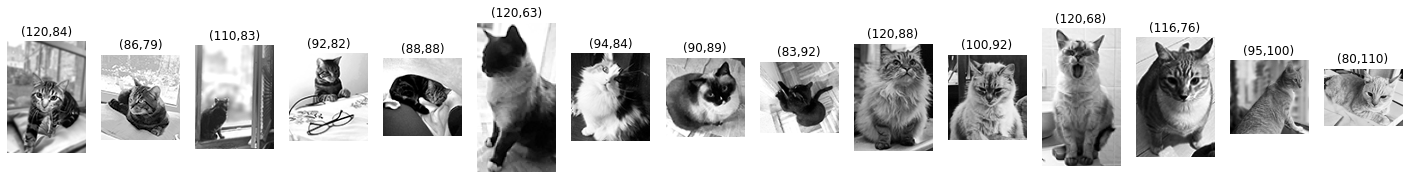

In [8]:
# Clean images: title is M × N
plt.figure(figsize=(25,10))

for i in range(NN):
    plt.subplot(1, NN, i+1);                         plt.imshow( img[i], cmap='gray')
    plt.title('({0},{1})'.format(M[i],N[i]));    plt.axis('off');
plt.show()

# Additional setups

We tune some parameters to check on the efficiency of the method:

In [9]:
clf = NFFTKernelRidge(sigma=1.0, norm = None, setup = 'default')                       # Instiatate the kernel ridge inner functions
def SSIM(img,u, M,N):  return ssim(img, u.reshape(M,N), data_range=u.max()-u.min())    # Quality measure
def SSIMG(img,u, M,N,  NN):                                                            # Composite quality via mean of means and individual ssim
    co = asarray([SSIM(img[i],u[i], M[i],N[i]) for i in range(NN)])
    return co.mean(), np.array(co)

In [10]:
# Invariant parameters
ρ = 5            # Patch radius
ρ̂ = 2*ρ+1        # Patch length
σ = 40.0         # Kernel spread
μ = 1e-2         # Scaling

## Working range

In [11]:
# Compute bounds
fᵂ = [255.0, 255*np.sqrt(3)]
#print( np.around(fᵂ,2))

ε = 3e-2
σᵁ = min(fᵂ)/np.sqrt(-np.log1p(-3e-2))
print( '{0:.0e}    {1:.2e} {3:.2e}'.format(ε, σᵁ, σᵁ**-2, np.exp(-((σᵁ)**-1 * max(fᵂ) )**2 )  ))
ε = 1e-308
σᴸ = max(fᵂ)/np.sqrt(-np.log(ε))
print( '{0:.0e}   {1:.2f}    {3:.2e}'.format(ε, σᴸ, σᴸ**-2, np.exp(-((σᴸ)**-1 * min(fᵂ) )**2 )  ))

3e-02    1.46e+03 9.13e-01
1e-308   16.59    2.15e-103


## Noisy samples

<div class="alert alert-block alert-info">
Now we create a noisy set with noisy images stored in list noisy.
</div>

In [12]:
'''Check if there is a sister dataset with noisy samples'''
folder_Noisy = Path(folder).parent.as_posix() + '/Training_Noisy/'
if not Path(folder_Noisy).exists():
    # If it doesn't exist, create sample
    
    # Fix seed
    rng = default_rng(10)

    # Additive noise: We select by default the noisiest sample
    σ2    = logspace(1,3,5)
    noisy = asarray([clip(img[i] + rng.normal(0, sqrt(σ2[-1]), img[i].shape), 0.0, 255.0) for i in range(NN)])

    print('\nCreating new sub-dataset with additive noise.')

    # Store data set
    Path(folder_Noisy).mkdir(parents=True, exist_ok=True)            # Create directory if not already available
    Noisy_Names = ['TN_' + '0{}.png'.format(i+1) if i < 9 else 'TN_' + '{}.png'.format(i+1) for i in range(NN)]
    [imwrite(folder_Noisy + Noisy_Names[nn], noisy[nn].astype(np.uint8)) for nn in range(NN)]
    
    print('\nData set is ready.')
else:
    # Load sample
    noisy = imread_collection( folder_Noisy + '/*.png', conserve_memory = False)       # Image read
    noisy = asarray([255 * img_as_float(rescale_intensity(i, out_range='uint8')) for i in noisy])
    
    if noisy.shape[0] != NN:
        print('Error: The number of images read is different than the number of images in the dataset.')
    else:
        print(NN, 'images read.')

15 images read.


In [13]:
f = noisy                           # Alias for ease
Quality = SSIMG(img,f, M,N,  NN)

Display images

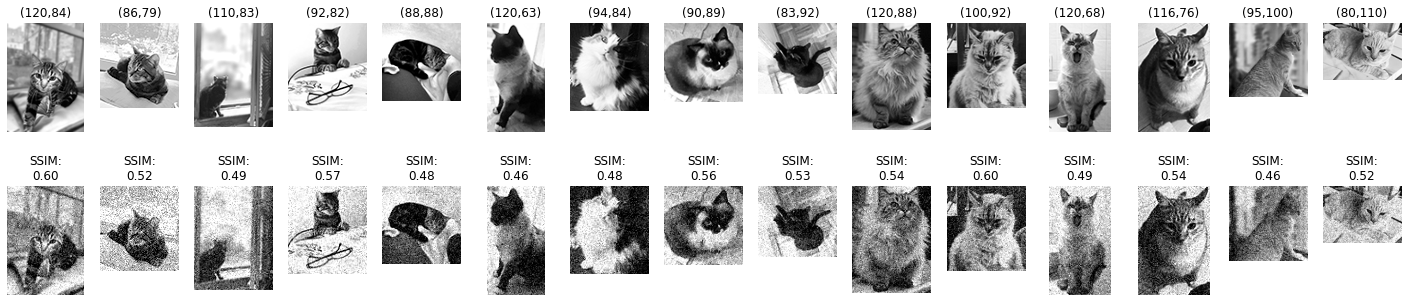

In [14]:
# Clean and noisy images: title is M × N

fig, ax = plt.subplots(2, NN, figsize=(25,5))

for i in range(NN):
    ax[0,i].imshow( img[i], cmap='gray')
    ax[0,i].set_title('({0},{1})'.format(M[i],N[i]));    ax[0,i].axis('off');    ax[0,i].set_anchor('N')
    
    ax[1,i].imshow( noisy[i], cmap='gray')
    ax[1,i].set_title('SSIM:\n{0:.2f}'.format(Quality[1][i]));    ax[1,i].axis('off');    ax[1,i].set_anchor('N')
    
fig.subplots_adjust(hspace=0.5)
plt.show()

If there's already a reconstruction stored locally, then we can compare results with the following code:

In [15]:
folder_Recovered = Path(folder).parent.as_posix() + '/Training_Recovered/'
if Path(folder_Recovered).exists():
    print('n ', '    Noisy SSIM', '      Recovered ')
    u = imread_collection( folder_Noisy + '/*.png', conserve_memory = False)       # Image read
    u = asarray([255 * img_as_float(rescale_intensity(i, out_range='uint8')) for i in u])
    for nn in range(NN):
        print(nn, around(SSIM(img[nn],noisy[nn],M[nn], N[nn]), 13), around(SSIM(img[nn],u[nn],M[nn],M[nn]),13), sep='   ')

## Nonlocal operator via fast summation

First we obtain the subkernels; i.e., $\Gamma_{i,\ell}$:

In [16]:
num_windows = np.empty(NN, dtype=int)
k_weight    = np.empty(NN)
Sub_Γℓ = []

print('–'*60)
for nn in range(NN):
    print('id: {0}'.format(nn))
    nm  = M[nn] * N[nn]
    ram_size = np.float64(1).itemsize * np.prod([nm,nm]) / (1024 ** 3)
    print( ' Mᵢ, Nᵢ, Mᵢ×Nᵢ, Γℓ[GB]:  {0:3d},  {1:3d},  {2:5d},  {3:7.2f}'.format(M[nn], N[nn], nm, ram_size) )
    print( ' SSIM:' + 16*' ' + '{0:.2f}'.format( Quality[1][nn]  ))
    
    '''
        Kernel Setup
    '''
    Fᵖᵃᵈ = pad(f[nn], ρ, mode='constant')
    X = sliding_window_view(Fᵖᵃᵈ, (ρ̂,ρ̂)).reshape(nm, ρ̂**2)
    
    '''Build windows'''
    start = time.time()
    # determine windows of features by their mis
    res_idx = clf.make_mi_scores(X, around(f[nn]).astype(int).ravel())
    windows = clf.get_mis_windows(res_idx)
    num_windows[nn] = len(windows)
    end = time.time()
    print( ' Windows:' + 13*' ' + '{0:d} ({1:.2f} s)'.format( num_windows[nn], end-start ))
    
    '''Weights'''
    # Compute kernel weights: equal weights that sup up to 1 or no weighting:
    k_weight[nn] = 1.0/num_windows[nn]
    
    '''Kernel as abstract object'''
    def W(σ, n = 64, m = 8, p = 8, Other_Setup = None):
        '''
        Set up the subkernel matrices that constitute the extended Gaussian ANOVA kernel

        Note
        ----
        Using the NFFT-approach, the kernel matrices are never computed explicitly.

        Parameters
        ----------
        X : ndarray
            The training data matrix.
        σ : float
            Shape of the kernel.
        n : even int
            The NFFT expansion degree.
        m : int ≤ max(N,M)
            Window cutoff.
        p : int
            Smoothness of the window function.

        Returns
        -------
        SubKernels : list of fastadj.AdjacencyMatrix
            Subkernel matrices for each window of features according to the selected window scheme.
        '''

        # Bound on window cutoff [Lemma 3.4]
        if n < max([4*m,12]):
            print('Changing n = {} to {}'.format(n, max([4*m,12])))
            n = max([4*m,12])

        # Setup approximation parameters
        NFFT_setup = fastadj.AccuracySetup(n,m,p,0,0)   if Other_Setup is None else   Other_Setup

        # Set diagonal → 0, since FastAdjacency package is targeted at graph Laplacian with zeros at the diagonal
        return [fastadj.AdjacencyMatrix(X[:,windows[l]], σ, NFFT_setup, 0.0) for l in range(num_windows[nn])]
    
    start = time.time()
    Sub_Γℓ.append( W(σ, Other_Setup = 'default') )
    end = time.time()
    print(' Setup:' + 15*' ' + '{0:.2f} s'.format( end - start ))
    
    print('–'*60)

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
id: 0
 Mᵢ, Nᵢ, Mᵢ×Nᵢ, Γℓ[GB]:  120,   84,  10080,     0.76
 SSIM:                0.60
 Windows:             41 (10.65 s)
 Setup:               0.32 s
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
id: 1
 Mᵢ, Nᵢ, Mᵢ×Nᵢ, Γℓ[GB]:   86,   79,   6794,     0.34
 SSIM:                0.52
 Windows:             41 (9.96 s)
 Setup:               0.22 s
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
id: 2
 Mᵢ, Nᵢ, Mᵢ×Nᵢ, Γℓ[GB]:  110,   83,   9130,     0.62
 SSIM:                0.49
 Windows:             41 (10.21 s)
 Setup:               0.28 s
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
id: 3
 Mᵢ, Nᵢ, Mᵢ×Nᵢ, Γℓ[GB]:   92,   82,   7544,     0.42
 SSIM:                0.57
 Windows:             41 (12.03 s)
 Setup:               0.23 s
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
id: 4
 Mᵢ, Nᵢ, Mᵢ×Nᵢ, Γℓ[GB]:   88,   88,   7744,     0.45
 SSIM:                0.48
 Windows: 

Now let's assemble the operators for all the subkernels:

In [17]:
def AK_n(nn):
    def AK(u):
        """
        Approximate the matrix-vector product AK*u, where AK = w * (K_1 + K_2 + ... + K_L).

        Note
        ----
        Since this function serves a LinearOperator from scipy, only one variable can be passed as input parameter.
        Any other variable needed has to be global, so that they can still be used within this function

        Parameters
        ----------
        u : ndarray
            The vector, whose product AK*u with the matrix AK shall be approximated.

        Returns
        -------
        AKu : ndarray
            The approximated matrix-vector product AK*u.
        """
        # Apply matrix-vector multiplication
        AKu = np.zeros_like(u)
        for l in range(num_windows[nn]):
            AKu += Sub_Γℓ[nn][l].apply(u)
        # Multiply each subKernel by its weight and collect into a sum
        AKu *= k_weight[nn]
        return AKu
    return AK

In [18]:
AKs = [AK_n(nn) for nn in range(NN)]

In [19]:
start = time.time()
η = asarray([AKs[nn]( ones(M[nn] * N[nn]) ) for nn in range(NN)])
end = time.time()
print('Sequential application: {0:.2f} s'.format( end - start ))

Sequential application: 16.55 s


---

We can improve this with a parallel implementation instead. We can take two paths here that define how our code works. (1) We can parallelise the action of all kernels; i.e., the list of functions that represent each kernel against the list of inputs representing each image, or (2) we can instead serialise the action of all kernels but parallelise the action of each subkernel. The former method allows us to build a block system, while the latter solves systems sequentially. The former method was implemented in a previous version alongside a multi block version of the dense preconditioners. However, we noticed that the number of CG iterations was increasing, maybe due to the relative norm criterion preventing CG to stop. As a result, if the problem was well conditioned and, say, five iterations were enough per image, it was observed that instead this number was multiplied by the total number of images. Hence, parallelising wasn't as effective.

In this version of the code we implement strategy (2).

In [20]:
nm   = np.prod([M,N],0).sum()                  # Total problem size
nm_s = np.prod([M,N],0)                        # Particular sizes
cuts = np.r_[0,np.cumsum(np.prod([M,N],0))]    # Indices to identify each subblock
# Check with [np.count_nonzero(np.concatenate(η)[ cuts[nn]:cuts[nn+1] ] - η[nn]) for nn in range(NN)]

In [21]:
import concurrent.futures
from concurrent.futures import ProcessPoolExecutor
import multiprocessing as mp                                                                                     
#mp.set_start_method("fork")
mp_fork = mp.get_context('fork')

In [22]:
Ones = [ones(M[nn] * N[nn]) for nn in range(NN)]

In [23]:
# Function to be executed in parallel
def compute_vector(nn, l, u):
    """Apply the function Sub_Γℓ[nn][l] to u[nn]"""
    #return funs[nn][l](u)
    return Sub_Γℓ[nn][l].apply(u)

In [24]:
def AK_n(nn):
    # Outer function selects the index nn and prepares the evaluator
    results = empty([num_windows[nn], nm_s[nn]])        # Initialize a structure to hold the results
    def AK(u):
        nonlocal nn  # Declare that nn is not a local variable
        """
        Approximate the matrix-vector product AK*u, where AK = w * (K_1 + K_2 + ... + K_L).

        Note
        ----
        Since this function serves a LinearOperator from scipy, only one variable can be passed as input parameter.
        Any other variable needed has to be global, so that they can still be used within this function

        Parameters
        ----------
        u : ndarray
            The vector, whose product AK*u with the matrix AK shall be approximated.

        Returns
        -------
        AKu : ndarray
            The approximated matrix-vector product AK*u.
        """
        
        # Apply matrix-vector multiplication in parallel
        with ProcessPoolExecutor(max_workers=8, mp_context=mp_fork) as executor:
            # Create all possible (nn, l) pairs and execute them in parallel
            futures = {executor.submit(compute_vector, nn, l, u): (nn, l) for l in range(num_windows[nn])}

            # Collect the results as they complete
            for future in concurrent.futures.as_completed(futures):
                nn, l = futures[future]
                try:
                    results[l] = future.result()
                except Exception as e:
                    print(f"An error occurred at (nn={nn}, l={l}): {e}")
        
        # Add up products and weight
        AKu = results.sum(0) * k_weight[nn]
        
        return AKu
    return AK

In [25]:
AKs = [AK_n(nn) for nn in range(NN)]

In [26]:
start = time.time()
ηᴾ = [AKs[nn](Ones[nn]) for nn in range(NN)]
end = time.time()
print('Parallel application - 8: {0:.2f} s'.format( end - start ))

Parallel application - 8: 5.22 s


In [27]:
[np.count_nonzero((ηᴾ - η)[nn]) for nn in range(NN)]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

We might need to modify this function a little for receiving vectorial inputs so that we can use CG with ease.

---

Each kernel will be ill-conditioned whenever $\lambda < 10^{-1}$:

In [28]:
print('–'*80)
for nn in range(NN):
    print('id: {0:2d} – '.format(nn), end = '')
    nm  = M[nn] * N[nn]
    ram_size = np.float64(1).itemsize * np.prod([nm,nm]) / (1024 ** 3)
    print( '(Γℓ)_ℓ: {0:6.2f} [GB] – '.format(ram_size * num_windows[nn]), end = '' )
    # Approximate numerical range
    E_A = μ * η[nn].max()
    e_A = μ * η[nn].min() * nm/(nm-1)
    print('Ŵᶠᵃˢᵗ(B) - {0}:' +  7*' ' + '{0:5.2f}  {1:8.2e}'.format( E_A, e_A ) )
    print('–'*80)

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
id:  0 – (Γℓ)_ℓ:  31.04 [GB] – Ŵᶠᵃˢᵗ(B) - {0}:        5.63  1.34e+00
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
id:  1 – (Γℓ)_ℓ:  14.10 [GB] – Ŵᶠᵃˢᵗ(B) - {0}:        5.46  8.06e-01
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
id:  2 – (Γℓ)_ℓ:  25.46 [GB] – Ŵᶠᵃˢᵗ(B) - {0}:        9.26  1.15e+00
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
id:  3 – (Γℓ)_ℓ:  17.39 [GB] – Ŵᶠᵃˢᵗ(B) - {0}:       13.66  5.29e-01
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
id:  4 – (Γℓ)_ℓ:  18.32 [GB] – Ŵᶠᵃˢᵗ(B) - {0}:        6.32  9.97e-01
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
id:  5 – (Γℓ)_ℓ:  17.46 [GB] – Ŵᶠᵃˢᵗ(B) - {0}:        7.87  9.86e-01
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
id:  6 – (Γℓ)_ℓ:  1

| id | 25 - U | 25 - L | 35 - U | 35 - L | 45 - U | 45 - L | 55 - U | 55 - L |
|----|----|----|----|----|----|----|----|----|
| 0 | 3.14 | 7.36e-01 | 6.07 | 1.20e+00 | 10.06 | 1.29e+00 | 14.63 | 1.89e+00 |
| 1 | 3.20 | 4.66e-01 | 5.71 | 8.32e-01 | 9.08 | 1.27e+00 | 13.28 | 1.97e+00 |
| 2 | 6.98 | 6.65e-01 | 9.86 | 1.09e+00 | 12.96 | 1.58e+00 | 16.22 | 2.05e+00 |
| 3 | 11.13 | 3.14e-01 | 14.27 | 5.53e-01 | 18.47 | 8.49e-01 | 22.51 | 1.31e+00 |
| 4 | 4.27 | 5.25e-01 | 6.10 | 9.17e-01 | 8.08 | 1.42e+00 | 10.61 | 2.14e+00 |
| 5 | 4.76 | 4.80e-01 | 7.15 | 9.11e-01 | 9.76 | 1.35e+00 | 12.95 | 1.82e+00 |
| 6 | 6.34 | 4.53e-01 | 9.10 | 8.18e-01 | 12.50 | 1.44e+00 | 15.54 | 2.15e+00 |
| 7 | 2.12 | 4.84e-01 | 4.09 | 8.41e-01 | 6.66 | 1.45e+00 | 9.68 | 1.86e+00 |
| 8 | 3.79 | 6.04e-01 | 6.01 | 1.11e+00 | 8.51 | 1.37e+00 | 11.15 | 1.88e+00 |
| 9 | 3.45 | 2.45e-01 | 6.58 | 5.26e-01 | 10.80 | 1.02e+00 | 15.86 | 1.42e+00 |
| 10 | 3.01 | 6.25e-01 | 4.91 | 1.10e+00 | 7.51 | 1.90e+00 | 10.27 | 2.56e+00 |
| 11 | 3.07 | 5.64e-01 | 5.46 | 8.88e-01 | 8.28 | 1.24e+00 | 11.12 | 1.69e+00 |
| 12 | 3.00 | 6.77e-01 | 5.66 | 1.14e+00 | 8.87 | 1.64e+00 | 12.47 | 2.81e+00 |
| 13 | 3.45 | 4.15e-01 | 6.65 | 7.57e-01 | 10.98 | 1.04e+00 | 15.67 | 1.75e+00 |
| 14 | 3.87 | 4.30e-01 | 7.30 | 8.00e-01 | 11.62 | 1.05e+00 | 16.40 | 1.32e+00 |


Largest smallest estimation of the algebraic connectivity:

In [29]:
max([μ * η[nn].min() * nm_s[nn]/(nm_s[nn]-1) for nn in range(NN)])

1.3363420417045357

This is the total memory consumption that would take to have all subkernels in matrix form:

In [30]:
ram_sizes = [np.float64(1).itemsize * ( (M[nn] * N[nn])**2 ) / (1024 ** 3) * num_windows[0] for nn in range(NN)]
print('{0:.0f} [GB]'.format(sum(ram_sizes)))

335 [GB]


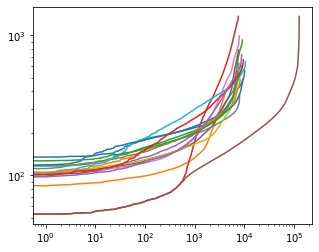

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(5,4))
for nn in range(NN):
    plt.plot(np.sort(η[nn]))

plt.plot( np.sort(np.concatenate(η)) )
plt.yscale('log'); plt.xscale('log')

## List of functions

Let us assemble a list of operators that will allow us to compute $A_i u_i$ with $u_i \in u$ for any index at will. This will require multiple runs of CG but of a smaller dimension than the full combined problem.

In [32]:
global λ
λ = 1.0    # Just for initialisation

In [33]:
def MatVecs(nn):
    # Define matrix vector multiplications for a choice of nn
    def matvec(v):
        nonlocal nn
        return μ * (η[nn] * v - AKs[nn](v)) + λ * v
    return matvec

In [34]:
A = [LinearOperator((nm_s[nn],nm_s[nn]), dtype=np.float64, matvec=MatVecs(nn), rmatvec=MatVecs(nn)) for nn in range(NN)]

In [35]:
uT = asarray([i.flatten() for i in img])    # Flatten clean images
ff = asarray([i.flatten() for i in f])      # Flatten noisy samples

In [36]:
A[nn](Ones[nn])

array([1., 1., 1., ..., 1., 1., 1.])

## Change of basis

We need to apply the change of basis for each subdimension.

In [37]:
from operator import setitem

In [38]:
# Basis change only depends on the dimension of each image, so we only have to define it once
not_e_1 = [ones(nm_s[nn]) for nn in range(NN)]
[setitem(not_e_1[nn], 0 , 0.0) for nn in range(NN)];

aux_h = [np.arange(nm_s[nn]) for nn in range(NN)]
aux_d = [np.reciprocal(np.sqrt( np.concatenate( ([nm_s[nn]], np.arange(2,nm_s[nn]+1) * np.arange(1,nm_s[nn]) ) ) ))  for nn in range(NN)]

In [39]:
def MV_basis_U_T(v, nn):
    '''
        Transpose of unitary transformation
    '''
    v = v if isinstance(v, np.ndarray) else asarray(v)    # Ensure an ndim array is given
            
    # We iteratively apply U.T to each slice
    U_T_v = aux_d[nn] * (np.roll( np.cumsum(v),1) - (aux_h[nn] * v))
    
    return asarray(U_T_v)

In [40]:
def MV_basis_U(v, nn):
    '''
        Unitary transformation
    '''
    v = v if isinstance(v, np.ndarray) else asarray(v)    # Ensure an ndim array is given
        
    # We iteratively apply U to each slice
    w   = aux_d[nn] * v
    U_v = ((w.sum() - np.cumsum(w)) * np.flip(not_e_1[nn])) - (aux_h[nn] * w) + w[0]
    
    return asarray(U_v)

In [41]:
all([allclose(MV_basis_U_T( MV_basis_U(Ones[nn],nn), nn), 1) for nn in range(NN)])

True

In [42]:
# Projections
Prec_RHS = asarray([MV_basis_U_T(ff[nn],nn) for nn in range(NN)])

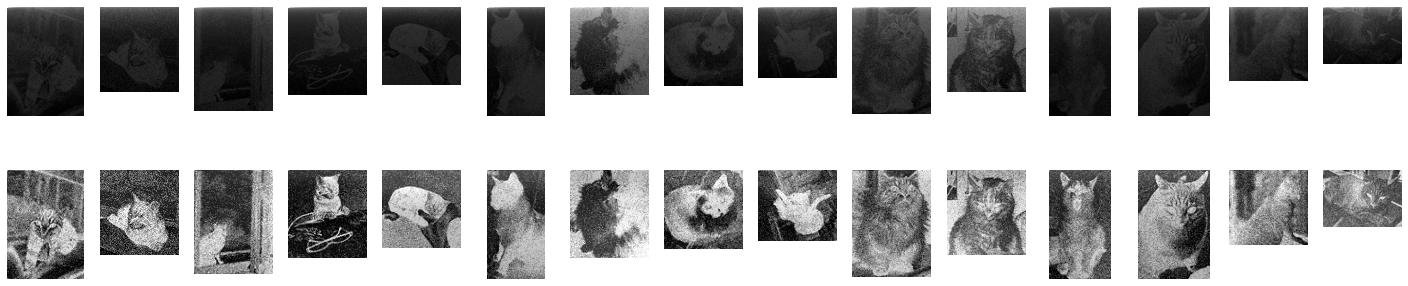

In [43]:
# Noisy images under new base
U_ff = [MV_basis_U(ff[nn],nn) for nn in range(NN)];      U_T_ff = [MV_basis_U_T(ff[nn],nn) for nn in range(NN)]
[setitem(U_T_ff[nn], 0 , 100.0) for nn in range(NN)];    # First entry has largest intensity, so we clip it
U_ff = [U_ff[i].reshape(M[i],N[i]) for i in range(NN)];    U_T_ff = [U_T_ff[i].reshape(M[i],N[i]) for i in range(NN)]

fig, ax = plt.subplots(2, NN, figsize=(25,5))

for i in range(NN):
    ax[0,i].imshow(   U_ff[i], cmap='gray');    ax[0,i].axis('off');    ax[0,i].set_anchor('N')
    ax[1,i].imshow( U_T_ff[i], cmap='gray');    ax[1,i].axis('off');    ax[1,i].set_anchor('N')
    
fig.subplots_adjust(hspace=0.5)
plt.show()

<div class="alert alert-block alert-warning">
<b>Subblocks</b>
</div>

We define a list of operators where each works on its corresponding $n_i-1$ subblock after the change of basis. For this, we need to have the backward operator which will project back each subvector into a $n_i$ dimensional space.

In [44]:
# Define subblock of system
def MAM_op(nn):
    # Define matrix vector multiplications for a choice of nn
    def MV_basis_MAM(v):
        nonlocal nn
        '''
            Project back v, change basis by U, apply A, then U.T, and project; i.e., (P U.T A U) P.T v
        '''
        w = np.concatenate( ([0.0], v) )
        w = MV_basis_U_T( A[nn].dot( MV_basis_U( w, nn ) ), nn )
        return w[1:]

    return MV_basis_MAM

In [45]:
MAM = [LinearOperator((nm_s[nn]-1,nm_s[nn]-1), dtype=np.float64, matvec=MAM_op(nn), rmatvec=MAM_op(nn)) for nn in range(NN)]

In [46]:
Vs = zeros(nm_s[nn]);    Vs[0] = 1.0
allclose(MV_basis_U_T(  A[nn].dot(MV_basis_U( Vs, nn )), nn), λ*Vs)

True

We will define an operator that works into each $n_i-1$ subblock after the change of basis. For this, we need to have the backward operator which will project back each subvector into a $n_i$ dimensional space.

In [2]:
nm   = np.prod([M,N],0).sum()

In [48]:
# Create a boolean mask for where to place the original values
w_mask = np.ones(nm, dtype=bool);    w_mask[cuts[:-1]] = False    # Zeros are located at cutoffs

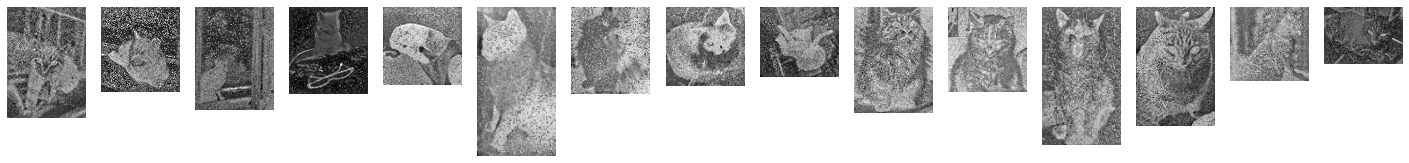

In [49]:
# Application of subblock but projected back
v_test = np.concatenate([MAM[nn](Prec_RHS[nn][1:]) for nn in range(NN)])
U_ff = np.zeros(nm)        # Initialize the backward projection
U_ff[w_mask] = v_test
U_ff = [U_ff[ cuts[nn]:cuts[nn+1] ].reshape(M[nn],N[nn]) for nn in range(NN)]

fig, ax = plt.subplots(1, NN, figsize=(25,5))

for i in range(NN):
    ax[i].imshow(   U_ff[i], cmap='gray');    ax[i].axis('off');    ax[i].set_anchor('N')
    
fig.subplots_adjust(hspace=0.5)
plt.show()

Similarly, define the preconditioners for each subproblem:

In [50]:
# Define sub preconditioners
def UDU_op(nn):
    # Define matrix vector multiplications for a choice of nn
    def Proj_Prec_Diag(v):
        nonlocal nn
        '''
            Project back v, change basis by U, apply M, then U.T, and project; i.e., (P U.T A U) P.T v
        '''
        w = np.concatenate( ([0.0], v) )
        w = MV_basis_U_T( diag_P[nn] * MV_basis_U(w,nn), nn )
        return w[1:]

    return Proj_Prec_Diag

In [51]:
UDU = [LinearOperator((nm_s[nn]-1,nm_s[nn]-1), dtype=np.float64, matvec=UDU_op(nn), rmatvec=UDU_op(nn)) for nn in range(NN)]

In [52]:
diag_P = η**-1    # Example for test

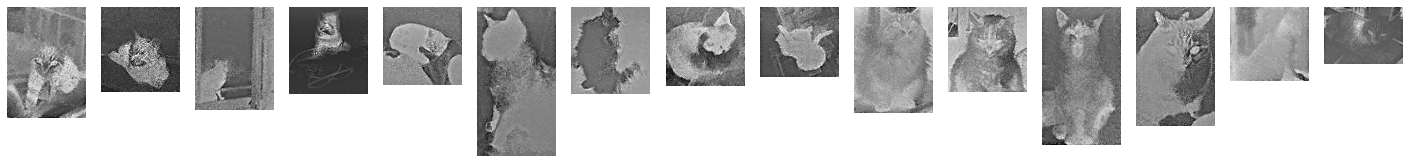

In [53]:
# Application of subblock but projected back
v_test = np.concatenate([UDU[nn](Prec_RHS[nn][1:]) for nn in range(NN)])
U_ff = np.zeros(nm)        # Initialize the backward projection
U_ff[w_mask] = v_test
U_ff = [U_ff[ cuts[nn]:cuts[nn+1] ].reshape(M[nn],N[nn]) for nn in range(NN)]

fig, ax = plt.subplots(1, NN, figsize=(25,5))

for i in range(NN):
    ax[i].imshow(   U_ff[i], cmap='gray');    ax[i].axis('off');    ax[i].set_anchor('N')
    
fig.subplots_adjust(hspace=0.5)
plt.show()

## Bilevel setup

<div class="alert alert-block alert-info">
Numba functions are defined to compute the objective function quickly.
</div>

In [54]:
# Numba functions
@jit(nopython=True, parallel=True)
def ar(x):    return np.around(x,4)
@jit(nopython=True, parallel=True)
def ar0(x):   return np.around(x,0)

In [55]:
@jit(nopython=True, parallel=True)
def Snorm(u):      return norm(u)**2                # Squared norm of a vector
@jit(parallel=True)
def Objective(u):                                   # Objective value 
    so = 0.0
    for nn in range(NN):
        so += Snorm(u[nn] - uT[nn])
    so /= (2 * NN)
    return so

In [56]:
"""First eval"""
ar(1.2); ar0(1.2); Objective(ff);

<div class="alert alert-block alert-info">
Basics are defined:
    
1. There are no numerical constraints related to $b$, thus we let it free and set $b=10^{10}$.

3. `nm` $=N\times M$, and `P` stores the preconditioner of matrix `A`.

4. Variables $u$ and $p$ indicate the state and adjoint variables, `fx` $=f(\lambda_k)$, `lamb` $=\lambda_k$, `l_u` is the RH side of the system $(\lambda + \Gamma - \gamma) u = \lambda f$, `l_p` is the RH of the system $(\lambda + \Gamma - \gamma) p = u-u^\top$, `u_f` stores the difference $u-f$, `C` stores $\Gamma$, `df` stores the value of the gradient at the actual point, `PA` stores the diagonal preconditioner  information which is updated with the help of `PC`, `sx` stores the best $\mathtt{SSIM}$ values, `us` will store the best solution in the sense of `sx`, and `sl` the matrix weight that got such solution.

4. `ff` and `uT` store the noisy and clean versions of the image. We use the former as a initial point if there's none defined.
</div>

In [57]:
global u, p, l_u, l_p, df, diag_P,   fx, sx, us, sl, u_f

if 'λ' not in globals():    λ = 0.1          # λ is known to be small
if 'u' not in globals():    u = ff.copy()
if 'p' not in globals():    p = ff.copy()

# Reserve memory
l_u, l_p, u_f = asarray([i.copy() for i in ff]), asarray([i.copy() for i in ff]), asarray([i.copy() for i in ff])
sx, sl = 0.0, 0.0
df = array(0.0)
diag_P = asarray([zeros(nm_s[nn]) for nn in range(NN)])

## Lower level functions

<div class="alert alert-block alert-warning">
<b>Solvers</b>
</div>

To evaluate the objective functional, we solve the state equation
\begin{align*}
    (u_i,\phi)_V + \big( \lambda(u_i-f_i), \phi \big) = 0, & &\forall \phi \in V, i\in [0:N-1].
\end{align*}
Then to get the derivative, we solve the adjoint equation
\begin{align*}
    (p_i,\phi)_V + \big( \lambda p_i, \phi \big) = \dfrac{1}{N} (u_i^\top - u_i,\phi), & &\forall \phi \in V, i\in [0:N-1].
\end{align*}
Then we get the derivate by the formula
\begin{align*}
    f'(\lambda) = \sum_{i=0}^{N-1}  ( u_i-f_i, p_i ).
\end{align*}

To solve the systems, we will use the block-to-decoupled dense preconditioners under $U$. For each $i \in [0:N-1]$, we project the problem to the basis given by $U_{n_i}$, then:
- The sub system $U_{n_i}^\top A_{n_i} U_{n_i} \mathbf{x} = U_{n_i}^\top \mathbf{f} = \mathbf{g}$ features a block-diagonal matrix. 
- We decouple the system, the first block is just $[\lambda]_{1,1} x_1 = g_1 $ with solution $x_1 = \lambda^{-1} g_1$.
- We apply preconditioned CG to the subsystem $\pi_{2,n_i}( U_{n_i}^\top A_{n_i} U_{n_i}) \mathbf{x}_{2:n_i} = \mathbf{g}_{2:n_i}$.
- We then assemble a solution $\mathbf{x}$ with the two blocks.
- Define $\mathbf{u}$ by transforming $\mathbf{x}$ back to the original basis and multiply by $\lambda$; i.e., $\mathbf{u} = \lambda U_{n_i}\mathbf{x}$ (notice that alternatively, we can define $\mathbf{u} = U_{n_i}[g_1, \lambda \mathbf{x}_{2:n_i}]$, which is better considering $\lambda^{-1}$ can suffer from cancelation errors).
- The resulting vector solves $ A_{n_i} \mathbf{u} = \lambda \mathbf{f}$.

In [58]:
# Create a counter that will return how many iterations of each method were performed
global g_cg_it
g_cg_it = 0
def solver_call(xk):
    global g_cg_it
    g_cg_it += 1

In [59]:
u = asarray([i.copy() for i in ff])
p = asarray([i.copy() for i in ff])

In [60]:
global cg_its

In [61]:
def obj_eval(λ):                  # ** Eval f and f' ** #
    global u, p, df,   diag_P, l_p,   g_cg_it, cg_its
    '''
        Evaluate state, compute adjoint, and return objective and derivative
    '''
    if λ < 0.0:        return 4*Snorm(u) + 1e+4, 1e+10    # In case something goes off, penalise negative values of λ
    
    # Build simple diagonal preconditioner [don't forget about μ]
    add(μ * η, λ, out = diag_P);    reciprocal(diag_P, out = diag_P);
    
    Prec_x_0 = asarray([MV_basis_U_T(u[nn],nn) for nn in range(NN)]) / λ     # Project initial solution
    
    cg_its = []
    for nn in range(NN):
        '''    State u    '''
        ## MAM x = g / s  ->  [sx] solves MAM uₒ = g, in particular we could take s = ‖g‖
        s = norm(Prec_RHS[nn][1:])
        g_cg_it = 0
        uₒ, status = cg(MAM[nn], Prec_RHS[nn][1:]/s, x0 = Prec_x_0[nn][1:]/s, tol = 1e-10, maxiter = 25, M = UDU[nn], callback = solver_call)
        uₒ *= s
        #print( '{0:.2e} {1:.2e}'.format( norm(MAM[nn](uₒ) - Prec_RHS[nn][1:]), norm(MAM[nn](uₒ) - Prec_RHS[nn][1:])/norm( Prec_RHS[nn][1:] ) ))

        # Build solution out of blocks
        u[nn][1:] = λ * uₒ                   # Second block
        u[nn][0]  = Prec_RHS[nn][0].copy()   # First subblock
        u[nn] = MV_basis_U(u[nn],nn)         # Go back to original basis
    
        cg_its.append(g_cg_it)
        
        
        '''    Adjoint p    '''
        subtract(uT[nn], u[nn], out = l_p[nn]);    l_p[nn] /= NN;    subtract(u[nn], ff[nn], out = u_f[nn])
        U_T__l_p = MV_basis_U_T(l_p[nn],nn)         # Define new RHS

        # Solve adjoint system
        pₒ, status = cg(MAM[nn], U_T__l_p[1:], x0 = MV_basis_U_T(p[nn],nn)[1:], tol = 1e-8, maxiter = 20, M = UDU[nn])

        # Build solution out of blocks
        p[nn][1:] = pₒ                              # Second block
        p[nn][0]  = (U_T__l_p[0] / λ)               # First subblock
        p[nn] = MV_basis_U(p[nn],nn)                # Go back to original basis
        
        
    '''    Derivative    '''
    df = asarray([np.sum([(u_f[nn] * p[nn]).sum() for nn in range(NN)])])
    return array(Objective(u)), df

Simple tests:

```
(25.0, 0.8, 23851630.02029342), (25.0, 0.9, 33718628.56707799)
(35.0, 0.8,  7571715.98255925), (35.0, 0.9,  9849847.84721147)
(40.0, 0.8,  5893414.15106971), (40.0, 0.9,  6723085.73584191)
(43.0, 0.8,  5456991.28326956), (43.0, 0.9,  5488590.50248591) *
(45.0, 0.8,  5493195.70205317), (45.0, 0.9,  5301299.01508036)
(47.0, 0.8,  5929637.46769644), (47.0, 0.9,  5607931.74858308)
(50.0, 0.8,  6434529.70205181), (50.0, 0.9,  5886527.51290808)
(55.0, 0.8,  7682579.44261636), (55.0, 0.9,  6806383.60077034)
```

In [62]:
start = time.time()
obj_eval(1.0)
end = time.time()
print('{0:.2f} s'.format(end-start))

113.71 s


In [63]:
array(Objective(u))

array(8697838.48646616)

In [63]:
array(Objective(u))

array(6651275.35450726)

In [64]:
cg_its

[10, 10, 11, 9, 10, 11, 10, 10, 11, 10, 10, 11, 10, 10, 10]

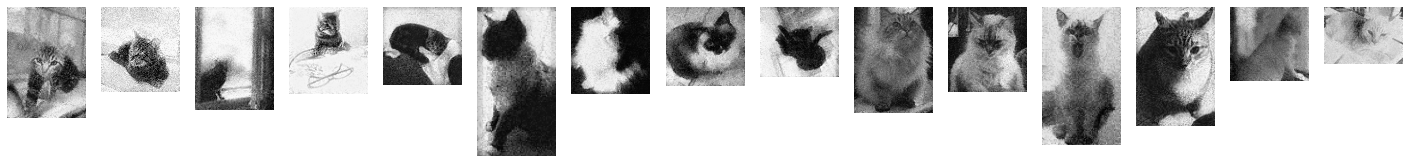

In [65]:
# Application of subblock but projected back
U_ff = [u[nn].reshape(M[nn],N[nn]) for nn in range(NN)]

fig, ax = plt.subplots(1, NN, figsize=(25,5))

for i in range(NN):
    ax[i].imshow(   U_ff[i], cmap='gray');    ax[i].axis('off');    ax[i].set_anchor('N')
    
fig.subplots_adjust(hspace=0.5)
plt.show()

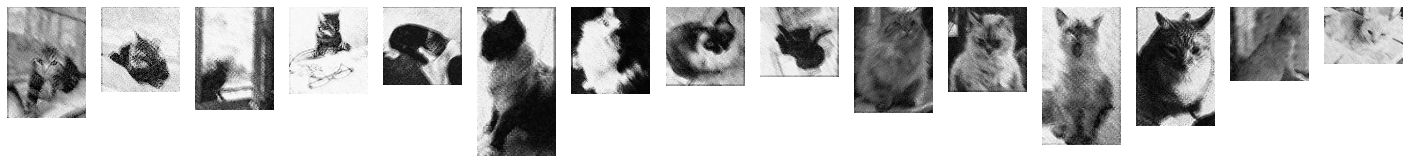

In [67]:
# Application of subblock but projected back
U_ff = [u[ nn].reshape(M[nn],N[nn]) for nn in range(NN)]

fig, ax = plt.subplots(1, NN, figsize=(25,5))

for i in range(NN):
    ax[i].imshow(   U_ff[i], cmap='gray');    ax[i].axis('off');    ax[i].set_anchor('N')
    
fig.subplots_adjust(hspace=0.5)
plt.show()

In [66]:
def obj_eval_a(λ):                  # ** Eval f ** #
    global u, p,   diag_P,   g_cg_it, cg_its
    '''
        Evaluate state and return objective
    '''
    if λ < 0.0:        return 4*Snorm(u) + 1e+4    # In case something goes off, penalise negative values of λ
    
    # Build simple diagonal preconditioner [don't forget about μ]
    add(μ * η, λ, out = diag_P);    reciprocal(diag_P, out = diag_P);
    
    Prec_x_0 = asarray([MV_basis_U_T(u[nn],nn) for nn in range(NN)]) / λ     # Project initial solution
    
    cg_its = []
    for nn in range(NN):
        '''    State u    '''
        ## MAM x = g / s  ->  [sx] solves MAM uₒ = g, in particular we could take s = ‖g‖
        s = norm(Prec_RHS[nn][1:])
        g_cg_it = 0
        uₒ, status = cg(MAM[nn], Prec_RHS[nn][1:]/s, x0 = Prec_x_0[nn][1:]/s, tol = 1e-10, maxiter = 25, M = UDU[nn], callback = solver_call)
        uₒ *= s
        #print( '{0:.2e} {1:.2e}'.format( norm(MAM[nn](uₒ) - Prec_RHS[nn][1:]), norm(MAM[nn](uₒ) - Prec_RHS[nn][1:])/norm( Prec_RHS[nn][1:] ) ))

        # Build solution out of blocks
        u[nn][1:] = λ * uₒ                   # Second block
        u[nn][0]  = Prec_RHS[nn][0].copy()   # First subblock
        u[nn] = MV_basis_U(u[nn],nn)         # Go back to original basis
    
        cg_its.append(g_cg_it)
        
    return array(Objective(u))
def obj_eval_b(λ):                  # ** Does not affect global variable u ** #
    global u, p,   diag_P,   g_cg_it, cg_its
    '''
        Evaluate state and return objective
    '''
    if λ < 0.0:        return 4*Snorm(u) + 1e+4    # In case something goes off, penalise negative values of λ
    
    # Build simple diagonal preconditioner [don't forget about μ]
    add(μ * η, λ, out = diag_P);    reciprocal(diag_P, out = diag_P);
    
    Prec_x_0 = asarray([MV_basis_U_T(u[nn],nn) for nn in range(NN)]) / λ     # Project initial solution
    
    cg_its = []
    uu = [empty(nm_s[nn]) for nn in range(NN)]
    for nn in range(NN):
        '''    State u    '''
        ## MAM x = g / s  ->  [sx] solves MAM uₒ = g, in particular we could take s = ‖g‖
        s = norm(Prec_RHS[nn][1:])
        g_cg_it = 0
        uₒ, status = cg(MAM[nn], Prec_RHS[nn][1:]/s, x0 = Prec_x_0[nn][1:]/s, tol = 1e-10, maxiter = 25, M = UDU[nn], callback = solver_call)
        uₒ *= s
        #print( '{0:.2e} {1:.2e}'.format( norm(MAM[nn](uₒ) - Prec_RHS[nn][1:]), norm(MAM[nn](uₒ) - Prec_RHS[nn][1:])/norm( Prec_RHS[nn][1:] ) ))

        # Build solution out of blocks
        uu[nn][1:] = λ * uₒ                   # Second block
        uu[nn][0]  = Prec_RHS[nn][0].copy()   # First subblock
        uu[nn] = MV_basis_U(uu[nn],nn)        # Go back to original basis
    
        cg_its.append(g_cg_it)
        
    return array(Objective(uu))
def obj_eval_d(λ):                  # ** Does not affect global variables u, p, df ** #
    global u, p, df,   diag_P, l_p,   g_cg_it, cg_its
    '''
        Evaluate state, compute adjoint, and return objective and derivative
    '''
    if λ < 0.0:        return 4*Snorm(u) + 1e+4, 1e+10    # In case something goes off, penalise negative values of λ
    
    # Build simple diagonal preconditioner [don't forget about μ]
    add(μ * η, λ, out = diag_P);    reciprocal(diag_P, out = diag_P);
    
    Prec_x_0 = asarray([MV_basis_U_T(u[nn],nn) for nn in range(NN)]) / λ     # Project initial solution
    
    cg_its = []
    uu = [empty(nm_s[nn]) for nn in range(NN)]
    pp = [empty(nm_s[nn]) for nn in range(NN)]
    for nn in range(NN):
        '''    State u    '''
        ## MAM x = g / s  ->  [sx] solves MAM uₒ = g, in particular we could take s = ‖g‖
        s = norm(Prec_RHS[nn][1:])
        g_cg_it = 0
        uₒ, status = cg(MAM[nn], Prec_RHS[nn][1:]/s, x0 = Prec_x_0[nn][1:]/s, tol = 1e-10, maxiter = 25, M = UDU[nn], callback = solver_call)
        uₒ *= s
        #print( '{0:.2e} {1:.2e}'.format( norm(MAM[nn](uₒ) - Prec_RHS[nn][1:]), norm(MAM[nn](uₒ) - Prec_RHS[nn][1:])/norm( Prec_RHS[nn][1:] ) ))

        # Build solution out of blocks
        uu[nn][1:] = λ * uₒ                   # Second block
        uu[nn][0]  = Prec_RHS[nn][0].copy()   # First subblock
        uu[nn] = MV_basis_U(uu[nn],nn)        # Go back to original basis
    
        cg_its.append(g_cg_it)
        
        
        '''    Adjoint p    '''
        subtract(uT[nn], uu[nn], out = l_p[nn]);    l_p[nn] /= NN;    subtract(uu[nn], ff[nn], out = u_f[nn])
        U_T__l_p = MV_basis_U_T(l_p[nn],nn)          # Define new RHS

        # Solve adjoint system
        pₒ, status = cg(MAM[nn], U_T__l_p[1:], x0 = MV_basis_U_T(p[nn],nn)[1:], tol = 1e-8, maxiter = 20, M = UDU[nn])

        # Build solution out of blocks
        pp[nn][1:] = pₒ                              # Second block
        pp[nn][0]  = (U_T__l_p[0] / λ)           # First subblock
        pp[nn] = MV_basis_U(pp[nn],nn)               # Go back to original basis
        
        
    '''    Derivative    '''
    dF = asarray([np.sum([(u_f[nn] * pp[nn]).sum() for nn in range(NN)])])
    return array(Objective(uu)), dF

## Lower level functions

<div class="alert alert-block alert-warning">
<b>Callback</b>
    
Here we compute two image measures: 
1. `sx` is the bestt mean SSIM value of the data set.
2.  `sgx` is the best SSIM value per image.
</div>

In [67]:
global sgx, sgl, ugs
sgx, sgl = zeros([2,NN])
us  = asarray([zeros(nm_s[nn]) for nn in range(NN)])
ugs = asarray([zeros(nm_s[nn]) for nn in range(NN)])

def call(λ):
    global u, sx, us, sl,  sgx, sgl
    s, sg = SSIMG(img,u, M,N, NN)
    BS    = False
    # global mSSIM analysis
    if s > sx:
        sx = s; sl = λ
        us = asarray([u[nn].copy() for nn in range(NN)])
        #print(λ, '->', sx)
        BS = True                    # A better SSIM value has been achieved
    # local SSIM
    indx = where(sg > sgx)
    sgx[indx] = sg[indx]
    sgl[indx] = λ
    ugs[indx] = u[indx].copy()
    return {'SSIM':sx, 'State': '*' if BS else ''}

# Solving the optimisation problem

## Optimisation routine

We will use a trust region limited memory algorithm for optimising $f$. In this setting, we will write $x_k$ for the iterates $\lambda_k$. Let us denote $\Lambda_\min$ and $\Lambda_\max$ the bounds on $\lambda$, and by $\delta\Lambda$ the gap between the two (i.e., their absolute difference).

Following the work of Yuan et al (2014), assuming 0 and $1$ as lower and upper bounds, respectively,
we introduce the quantity $\xi_k := \min\big\{\beta_k, c \|\nabla f(x_k)\|\big\} $, where $\beta_k$ and $c$ are positive constants such that $ 0 < \beta_k < \frac{1}{2} \delta\Lambda $, and define the strongly-active and inactive index sets by
\begin{align}
    A_k &:= \big\{ i \in \{1, \dots,n\}: \, x_{k,i}
            \leq \Lambda_\min + \xi_k \lor x_{k,i} \geq \Lambda_\max -  \xi_k \big\},	
            \label{ec:active_set}
    \tag{1.a}
    \\
    I_k &:= \{1, \dots,n\} \setminus A_k = 
            \big\{ i \in \{1, \dots,n\}: \, \Lambda_\min+ \xi_k < x_{k,i} < \Lambda_\max -  \xi_k \big\},	\label{ec:inactive_set}
    \tag{1.b}
\end{align}
respectively, where $x_{k,i}$ is the $i$-th element of $x_k$.
Now, suppose the current trust region radius is $\widehat\Delta >0$, with its maximum value $\Delta_{\max} > 0$, and let $\kappa > 0$. We can obtain a search direction at step $x_k$ as follows:

* **Projected gradient direction:** Compute
\begin{equation}\label{ec:proy_grad}
d^G_{*k} (\widehat\Delta) := \max\left\{ \Lambda_\min, \min\left\{\Lambda_\max , \,x_k - \dfrac{\widehat\Delta}{\Delta_{\max}}  \kappa_k \nabla f(x_k) \right\} \right\} - x_k.
\tag{PG}
\end{equation}

* **Projected trust-region direction:** We look for a direction $d^{\text{tr}}_{*k} (\widehat\Delta)$ defined for each index of the sets $A_k$ and $I_k$, respectively.
We begin with $A_k$, for which we let $v_k^{A_k}$ be the subvector
\begin{equation}
    v_k^{A_k} :=
    \begin{cases}
        x_{k,i} - \Lambda_\min     & \text{if } x_{k,i} \leq \Lambda_\min + \xi_k,  \\
        \Lambda_\max - x_{k,i} & \text{if } x_{k,i} \geq \Lambda_\max - \xi_{k}.
    \end{cases}
\end{equation}
Then we define the subvector
\begin{equation}
    d^{A_k}_{*k} (\widehat\Delta)  := \min \left\{ 1, \dfrac{\widehat\Delta}{\|v_k^{A_k}\|} \right\} v_k^{A_k}.
    \tag{SV}
\end{equation}
For the inactive set $I_k$ we solve a reduced trust-region subproblem. Here, let $B_k$ be partitioned into two submatrices $B_k^{A_k} $ and $B_k^{I_k} $, obtained by taking columns of $B_k$ indexed by $A_k$ and $I_k$, respectively. Let $ d^{I_k}_{*k} (\widehat\Delta) $ be a solution of the following TR–subproblem
\begin{equation} \label{ec:subvector_inactive}
\begin{aligned}
        \min \;\, & d^\top \Big[ \big(B_k^{I_k}\big)^\top \big( \nabla f(x_k) + B_k^{A_k} d^{A_k}_{*k}  \big) \Big] + \dfrac{1}{2} d^\top \big(B_k^{I_k}\big)^\top B_k^{I_k} d\\
\text{s.t. } & \|d\| \leq \widehat\Delta.
\end{aligned}
\tag{TR}
\end{equation}
The projected trust-region direction is then defined as
\begin{equation}
    d^{\text{tr}}_{*k} (\widehat\Delta) := \max\left\{ \Lambda_\min, \min\left\{ \Lambda_\max, \, x_k + \begin{pmatrix} d^{A_k}_{*k} (\widehat\Delta) \\ d^{I_k}_{*k} (\widehat\Delta)  \end{pmatrix}\right\} \right\} - x_k.
\end{equation}
Since this direction may not be a descent direction for $f$ for far iterates, we use a convex combination with the gradient direction as follows.

* **Search direction:** Let
\begin{equation}
d_{* k} (\widehat\Delta)  := t_{*k} d_{*k}^G(\widehat\Delta) + (1- t_{*k}) d^{\text{tr}}_{*k} (\widehat\Delta),
	\end{equation}
	where $t_{*k}$  is a solution of the following one-dimensional problem
	\begin{equation}\label{ec:search_dir_one_dim}
		\min_{t \in [0,1]} f\big( x_k + t d_{*k}^G(\widehat\Delta) + (1- t) d^{\text{tr}}_{*k} (\widehat\Delta) \big).
        \tag{SD}
	\end{equation}

<div class="alert alert-block alert-warning">
Yuan, G., Wei, Z. & Zhang, M. An active-set projected trust region algorithm for box constrained optimization problems. J Syst Sci Complex 28, 1128–1147 (2015). https://doi.org/10.1007/s11424-014-2199-5
</div>

<div style="background-color:rgba(0, 0, 0, 0.0470588); vertical-align: middle; padding:5px 0; padding-left: 40px;">
<h2 style="color: #5e9ca0;">Projected Trust-Region Algorithm with L-BFGS Update</h2>
<ol>
<li>Choose \(x_0 \) and a symmetric positive definite matrix \(H_0\). Let constants satisfy \(0 < \beta_0 < \frac{1}{2} \delta\Lambda \), \(c>0\), \(0 < \nu_1 < 1 < \nu_2\), \(0<\tau_1<\tau_2<1\), \(\upsilon \in (0,1)\), \(\omega \in \mathbb{R}\), \(\Delta_0 >0\), and \( \Delta_{\max} > \Delta_{\min} > 0\). Now set \(m \in \mathbb{N}\), \(k = 0\), and \(B_0 =H_0^{-1}\)
    </li>
    
<p><bf> \(\mathbf{Repeat}\)</bf></p>
    
<ol>
<li>
    Let \(\Delta_k := \min\big\{ \Delta_{\max}, \max\{\Delta_{\min}, \Delta_k\} \big\}\) and \(\widetilde\Delta = \Delta_k\).
</li>
    
<li> Determine index sets \(A_k\) and \(I_k\) by (1.a) and (1.b).
</li>
    
<li> Find \(d_{*k}^{\text{tr}} (\widetilde\Delta)\) by determining \(d_{*k}^{A_k} (\widetilde\Delta)\) and \(d_{*k}^{I_k} (\widetilde\Delta)\) as in (SV) and (TR).
</li>
    
<li> Set
    \[
        \kappa_k := \min\left\{ 1, \dfrac{\Delta_{\max}}{\big\| \nabla j(x_k) \big\|}, \dfrac{\omega}{\big\| \nabla j(x_k) \big\|} \right\}.
    \]
</li>


<li>Compute \( d_{*k}^G(\widetilde\Delta)\) and \(t_{*k}\) as in (PG) and (SD), respectively. Let
    \[
        d_{*k} (\widehat\Delta)  := t_{*k} d_{*k}^G(\widehat\Delta) + (1- t_{*k}) d^{\text{tr}}_{*k} (\widehat\Delta).
    \]
</li>
    
    
<li>Compute
    \[
        r_{*k} := \dfrac{ j(x_k + d_{*k}) - j(x_k)}{ \nabla j(x_k)^\top d_{*k} (\widehat\Delta) + \frac{1}{2} \, d_{*k} (\widehat\Delta)^\top B_k d_{*k} (\widehat\Delta)}
    \]
</li>
    
    
<li> \(\mathbf{If}\) \(j(x_k) - j \big(x_k + d_{*k} (\widehat\Delta) \big) \geq -\upsilon \nabla j (x_k)^\top d^G_{*k} (\widehat\Delta)\) and \(r_{*k} \geq \tau_1\) hold \(\mathbf{then}\)
</li>
    
<ol>
    <li> Let \(q_k := d_{*k}\), \(x_{k+1} := x_k + d_{*k}\), \(\beta_k = \widehat\Delta \), and
        \[
            \Delta_{k+1} :=
            \begin{cases}
                \widehat\Delta & \text{if } \tau_1 < r_{*k} < \tau_2,
                \\
                \nu_2 \widehat\Delta & \text{if } r_{*k} \geq \tau_2.
            \end{cases}
        \]
    </li>
    <li> Let \(\widehat m := \min\{k+1,m\}\). </li>
    <li> Update \(B_k\) with the \(n \times \widehat m\) matrices \(S_k\) and \(Y_k\) to get \(B_{k+1} \). </li>
    <li> Let \(k = k+1\) and return to step A. </li>
</ol>
    

    
<li> \(\mathbf{else}\) </li>
<ol>    
    <li>Let \(\widehat\Delta = \tau_1 \widehat\Delta\). </li>
<li> Return to step C.</li>
</ol>
</ol>
    
<p><bf> \(\mathbf{until}\, x_{k}\) satisfies some stopping criteria.</bf></p>
</div>

<div class="alert alert-block alert-warning">
<b>Limited memory</b>
</div>

The limited memory BFGS method approximates the inverse of the Hessian of a functional $j$ at iteration $k+1$, say $H_{k+1}$, without storing the dense matrices $H_k$ at each iteration. Instead, it stores $m$ correction pairs $ \{q_i, d_i\}_{i\in [k-1: k-m]} \subset\mathbb{R}^{n,2} $, where
\begin{equation}
    q_i := x_{i+1} - x_{i}
    \qquad\text{and}\qquad
    d_i := \nabla f(x_{i+1}) - \nabla f(x_{i}),
\end{equation}
that contain information related to the curvature of $f$. Byrd et al (1994) introduced a compact form to define the limited memory matrix $ B_k = H_k^{-1} $ in terms of the $ n\times m $ correction matrices
\begin{equation}
    S_k :=
        \begin{pmatrix}
            q_{k-m} & \cdots & q_{k-1}
        \end{pmatrix}
    \qquad\text{and}\qquad
    Y_k :=
        \begin{pmatrix}
            d_{k-m} & \cdots & d_{k-1}
        \end{pmatrix}.
\end{equation}
%
The main idea of the algorithm is that the matrix $S_k^\top Y_k$ can be written as the sum of the following three matrices:
\begin{equation}
    S_k^\top Y_k = L_k + D_k + R_k,
\end{equation}
where $L_k$ is strictly lower triangular, $D_k$ is diagonal, and $R_k$ is strictly upper triangular.

For $\theta > 0$, if the correction pairs satisfy $ q_i^\top d_i > 0 $, then the matrix obtained by updating $\theta I_n$ with the BFGS formula and the correction pairs after $k$-times can be written as
\begin{align}
    B_k &:= \theta I_n - W_k M_k W_k^\top,
\end{align}
where $W_k$ and $M_k$ are the block matrices given by
\begin{align}
W_k &:= \begin{pmatrix}	Y_k & \theta S_k \end{pmatrix},
\\
M_k &:= \begin{pmatrix}	-D_k & L_k^\top \\  L_k &  \theta S_k^\top S_k	\end{pmatrix}^{-1}.	\label{lbfgs-Bc}
\end{align}
Note that, as $M_k$ is a $2m\times 2m$ matrix, the cost of computing the inverse in the last formula is negligible. Hence, using the compact representation for $B_k$, various computations involving this matrix become inexpensive, as is the case of the product of $B_k$ times a vector.

One aspect of the BFGS method is that each update is positive definite. As the limited memory formula for $B_k$ can also be stated as
\begin{equation}
	B_k = V_k^\top H_k V_k + p_k q_k q_k^\top,
\end{equation}
with $ p_k := \big( q_k^\top d_k \big)^{-1}$ and $V_k :=  I_n - p_k d_k q_k^\top$. Thus, we can guarantee positive definiteness using Powell's method in which $d_k$ is redefined as
\begin{equation}
	d_k :=
	\begin{cases}
		d_k		& \text{if } q_k^\top d_k \geq 0.2 q_k^\top B_k d_k,
		\\
		\alpha_k d_k + (1-\alpha_k) B_k q_k & \text{otherwise},
	\end{cases}
\end{equation}
where $\alpha_k := \frac{0.8 q_k^\top B_k q_k}{q_k^\top B_k q_k - q_k^\top d_k}$. If the updated $q_k^\top d_k$ is too close to zero, to maintain numerical stability, the limited memory matrix is not updated.

<div class="alert alert-block alert-warning">
Richard H. Byrd, Jorge Nocedal, and Robert B. Schnabel. Representations of quasi-Newton matrices and their use in limited memory methods. Mathematical Programming, 63(1- 3):129–156, jan 1994.
</div>

In [68]:
xk = array([λ])    # Initial point

In [69]:
dim = 1            # dimension of the parameter to optimize 

In [70]:
'''Reserve memory'''
cLM   = 1
S     = append([1], zeros(dim-1)).reshape(dim,1);                        Y = S.copy()
SY, O = empty([cLM,cLM], dtype=float), zeros([cLM,cLM], dtype=float)

In [71]:
Λᵐ, Λᴹ = 1e-9, 3.0    # Fix limits of box

In [72]:
'''Project into box'''
@jit
def proj(x): return maximum(Λᵐ, minimum(x,Λᴹ))
proj(xk);

In [73]:
'''Functions needed for LM operations'''
def Limited():
    def B_eval(W,MI,dk):
        db  = dk.copy();         db *= θᵪ;        db -= W.dot(MI.dot(W.T.dot(dk)));            return db
    def BA_eval(W,MI,Uk,dUk):
        db = zeros(dim, dtype='float')
        db[Uk] = dUk;            db *= θᵪ;        db -= W.dot(MI.dot(W[Uk,:].T.dot(dUk)));     return db
    def BAT_eval(W,MI,Uk,dUk):
        db = dUk[Uk].copy();     db *= θᵪ;        db -= W[Uk,:].dot(MI.T.dot(W.T.dot(dUk)))
        return db
    def H_eval(WH,MH,dk):
        db  = dk.copy();         db /= θᵪ;        db += WH.dot(MH.dot(WH.T.dot(dk)));          return db
    def HA_eval(WH,MH,Uk,dUk):
        db = zeros(dim, dtype='float');   db[Uk] = dUk;    db /= θᵪ;    db += WH.dot(MH.dot(WH[Uk,:].T.dot(dUk)))
        return db
    def HAT_eval(WH,MH,Uk,dUk):
        db = dUk[Uk].copy();     db /= θᵪ;     db += WH[Uk,:].dot(MH.T.dot(WH.T.dot(dUk)));   return db
    return B_eval, BA_eval, BAT_eval, H_eval, HA_eval, HAT_eval

A Limited Memory BFGS method is used. The matrices will be constantly updated.

In [74]:
def LBFGS(S,Y,SY, θ):
    W   = append(Y, θ*S, axis=1);  np.dot(S.T, Y, out=SY);  L = tril(SY,k=-1);  D = diagflat(SY.diagonal())
    M0  = append(-D,L.T, axis=1);    M1 = append(L, θ*S.T.dot(S), axis=1);    MM = append(M0,M1, axis=0)
    MI  = inv(MM)
    WH  = W.copy();       WH /= θ;    R = inv(triu(SY,k=0));            MH0 = append(O, -R, axis=1)
    MH1 = append(-R.T, R.T.dot((D + Y.T.dot(Y)/θ).dot(R)), axis=1);     MH  = append(MH0,MH1, axis=0)
    return MI, MH, W, WH
def LSR1(S,Y,SY, θ):
    W  = Y - θ*S;  np.dot(S.T, Y, out=SY);  L = tril(SY,k=-1);  D = diagflat(SY.diagonal())
    MM = D + L + L.T - θ*S.T.dot(S);    MM *= -1
    while np.linalg.det(MM) == 0.0:
        θ *= 0.5
        W  = append(Y, θ*S, axis=1);  np.dot(S.T, Y, out=SY);  L = tril(SY,k=-1);  D = diagflat(SY.diagonal())
        M0 = append(-D,L.T, axis=1);    M1 = append(L, θ*S.T.dot(S), axis=1);     MM = append(M0,M1, axis=0)
    MI = inv(MM)
    WH = W.copy();    WH /= θ;    R = triu(SY,k=0)
    MH = inv( R + R.T - D - (1.0/θ)*Y.T.dot(Y))
    return MI, MH, W, WH

## Algorithm

In [75]:
''' Create structures to store information from iterates '''
save_iter = True            # Do we store information for every iteration?
if save_iter:
    ei_keys    = ['it', 'obj', 'time', 'λ', 'df', 't_k', 'norm']
    every_iter = {a:[] for a in ei_keys}
    
save_critical = True        # Do we store information for every "critical" iteration?
critical = 2                # An iteration is critical after some iterations
if save_critical:
    ec_keys        = ['it', 'obj', 'time', 'λ', 'df']
    every_critical = {a:[] for a in ec_keys}

In [76]:
xₖ = asarray([λ]).copy()

All parameters involved in the algorithm will have a "ᵪ" decorator added to them to avoid confusion.

In [77]:
''' Setting TR parameters '''
αᵪ = [0.5, 2.0]                  # TR scaling factors  0 < αᵪ[0] < 1 < αᵪ[1]
ρᵪ = [1e-5,0.75]                 # TR acceptance ratio (Success & Increase region)  0 < ρᵪ[0] < ρᵪ[1] < 1
Λᵪ = [Λᵐ, Λᴹ]                    # Box limits
σᵪ = 0.01                        # Armijo–Goldstein parameter for linesearch  0 < σᵪ < 1 (l/2L?) [0.00025]
ηᵪ = 0.9                         # Normalisation scale for gradient directions  0 < ηᵪ < 1
δᵪ = 0.25 * 0.99 * (Λᴹ-Λᵐ)       # Ambiguity threshold for active set estimation  δᵪ < ½ (ℓ-u)  [small>linear]
cᵪ = 1.5                         # Gradient scaling factor for active set estimation  c > 0  [goes along pᵪ]
pᵪ = 0.35                        # 0 < pᵪ < 1 [comment after Lemma 9.7 in 10.1007/978-1-4757-3279-5_9]
mᵪ = 5                           # Memory size for LM
θᵪ = 1.0                         # Initial weight for basic Hessian approximation
æ = 1e+2
Δᵪ = [1.0/æ, 5.0/æ, 1e-6, 1.0/æ]       # TR radii: Δₖ, Δₘₐₓ, Δₘᵢₙ, Δ̂

''' Additional tolerances '''
εᵪ_LM    = 1e-4                  # Tolerance of curvature sₖᵀyₖ > ε
εᵪ_HCond = 1e-4                  # Himmeblau stopping condition for small functional values
εᵪ_Ha    = 5e-13                 # Absolute Himmeblau criteria
εᵪ_Hb    = 1e-13                 # Relative Himmeblau criteria

In [89]:
''' Initial iteration (xₒ, fₒ, dfₒ) '''
fₖ, dfₖ  = obj_eval(xₖ)
Obj_Res = [];              Obj_Res.append(fₖ.tolist())
''' Initial iteration counter and maximum number of iterations '''
kᵪ      = 0;
Max_It  = 20

In [90]:
Method = 'BFGS'

In [91]:
# Control if TR is increased for achieving a larger search
#grow   = False           # Activates growth to expand search
#f_grow = array(1e+10)    # Limits growth size

timed = 0.0              # Initialise clock

''' Run algorithm for the given settings '''
for kᵪ in range(Max_It):
    
    # Print header of table
    if kᵪ == 0:
        print('{0:^5s}|{1:^11s}|{2:^11s}|{3:^11s}|'.format('#','λ', 'f(λ)','∇f(λ)'), end='')
        print('{0:^5s}|{1:^5s}|{2:^8s}|{3:^11s}|{4:^11s}'.format('#Aₖ','#Iₖ','tₖ','dₖ', 'Time'))

        print('–'*110)
        
        # Report initial iteration info
        if save_iter:
            every_iter['it'].append( kᵪ )
            every_iter['obj'].append( fₖ )
            every_iter['time'].append( timed )
            every_iter['λ'].append( xₖ.item() )
            every_iter['df'].append( dfₖ.item() )
            every_iter['t_k'].append( 0.0 )
            every_iter['norm'].append( abs(dfₖ.item()) )
        if kᵪ % critical == 0:
            every_critical['it'].append( kᵪ )
            every_critical['obj'].append( fₖ )
            every_critical['time'].append( timed )
            every_critical['λ'].append( xₖ.item() )
            every_critical['df'].append( dfₖ.item() )
            
        print('{0:^5d}|{1:^11.3e}|{2:^11.3e}|{3:^11.2e}|'.format(kᵪ-1, xₖ.item(), fₖ, dfₖ.item() ) )
    
    # *************** #
    # Stationarity test
    if np.all(dfₖ[xₖ == Λᵪ[0]] >= 0.0) & np.all(dfₖ[xₖ == Λᵪ[1]] <= 0.0) & allclose(dfₖ[logical_and(xₖ>Λᵪ[0], xₖ<Λᵪ[1])], 0.0):
        print('Optimality reached.')
        break
        
    it_time = time.time()                                # Clock
    
    # *************** #
    # 1. TR radii update
    Δᵪ[0]  = min(Δᵪ[1], max(Δᵪ[2], Δᵪ[0]))               # Δₖ
    Δᵪ[-1] = Δᵪ[0]                                       # Δ̂
    
    # *************** #
    # 2. Active-set estimation: Determine the index sets Aₖ and Iₖ
    ξᵪ = min(δᵪ, cᵪ * norm(dfₖ) ** pᵪ )                  # Estimate of inactive region (12)
    Iₖ = where( (xₖ >  Λᵪ[0] + ξᵪ) & (xₖ <  Λᵪ[1] - ξᵪ) )[0]            # Inactive set (13)
    Aₖ = where( (xₖ <= Λᵪ[0] + ξᵪ) + (xₖ >= Λᵪ[1] - ξᵪ) )[0]            # Active set (13)
    
    # *************** #
    # 3. Trust-Region Subproblem
    
    # ––––––––– #
    # Limited memory matrix
    if Method == 'BFGS':
                 MI, MH, W, WH = LBFGS(S,Y,SY, θᵪ)       # BFGS
    else:        MI, MH, W, WH = LSR1(S,Y,SY, θᵪ)        # SR1
    #
    B_eval, BA_eval, BAT_eval, H_eval, HA_eval, HAT_eval = Limited()
    
    # ––––––––– #
    # Gradient scaling
    γᵪ  = -min(1.0, Δᵪ[1]/norm(dfₖ), ηᵪ/norm(dfₖ))        # Scaling factor (24)
    #γᵪ = -min(1.0, Δᵪ[1]/norm(dfₖ))
    
    # ––––––––– #
    # Subvector of estimated active elements
    vₖ      = full(dim, np.nan)                           # Initialise
    Aˡᵪ, Aᵘᵪ = (xₖ <= Λᵪ[0] + ξᵪ), (xₖ >= Λᵪ[1] - ξᵪ)     # Collect active indices
    if Aˡᵪ:
        vₖ[Aˡᵪ] = xₖ[Aˡᵪ] - Λᵪ[0]                          # Lower side
    if Aᵘᵪ:
        vₖ[Aᵘᵪ] = Λᵪ[1] - xₖ[Aᵘᵪ]                          # Upper side
    vAₖ     = vₖ[Aₖ]                                       # Extract info
    
    # ––––––––– #
    # Reserve memory for TR direction
    dTRₖ = ones(dim)
    
    '''
    # ––––––––– #
    # TR iteration'''
    kᵢₙₙₑᵣ = 0                                            # Inner iteration counter
    while 1 != 2:
        # ///// #
        # 3.a Projected Gradient Direction
        #wGₖ = max( (Δᵪ[-1]/Δᵪ[1]) * γᵪ, -1e-2)            # Scaling + prevention of the too large stepsizes
        wGₖ = (Δᵪ[-1]/Δᵪ[1]) * γᵪ                        # Just scaling 
        dGₖ = proj(xₖ + wGₖ * dfₖ) - xₖ
        
        # ///// #
        # Active direction [prevent empty division]
        wAₖ = min(1.0, Δᵪ[-1]/norm(vAₖ) ) if (Aₖ.size > 0 and norm(vAₖ) > 0 ) else 0.0
        dAₖ = wAₖ * vAₖ if (Aₖ.size > 0) else array([])
        
        # ///// #
        # 3.b Reduced TR subproblem in inactive set
        if Iₖ.size > 0:
            #dd      = dfₖ.copy()                             # Uncomment if the active info is not to be
            #dd[Ak] += dAk                                   # considered and comment c below.
            
            BBdₐ = BAT_eval(W,MI,Iₖ, BA_eval(W,MI,Aₖ,dAₖ) + dfₖ)             # Linear part
            #BBdₐ = BAT_eval(W,MI,Iₖ, dfₖ)                                  # If Aₖ is not to be considered
            
            def mv(d):    return  BAT_eval(W,MI,Iₖ, BA_eval(W,MI,Iₖ,d) )    # Product (Bₖᴵ)ᵀ(Bₖᴵ) d
            BB = LinearOperator((Iₖ.size,Iₖ.size), matvec=mv, rmatvec=mv)
            def fv(d):    return  BBdₐ.dot(d) + 0.5 * d.dot(BB(d))         # Subproblem objective
            def gv(d):    return  BBdₐ + BB(d)                             # Gradient of subproblem
            
            A_guess = HAT_eval(WH,MH,Iₖ, HA_eval(WH,MH,Iₖ, -BBdₐ))          # Unconstrained solution
            B_guess = where( (A_guess > Δᵪ[-1]) + (A_guess < -Δᵪ[-1]), dfₖ[Iₖ], A_guess)    # Constrained guess
            #B_guess = clip(A_guess, -Δᵪ[-1], Δᵪ[-1])                        # Alternatives
            #B_guess = clip(dfₖ[Iₖ], -Δᵪ[-1], Δᵪ[-1])
            
            InactiveSubProb = minimize(fv, x0 = B_guess, method='L-BFGS-B', jac = gv,
                                       bounds = Bounds(lb = -Δᵪ[-1], ub = Δᵪ[-1]), options = {'maxiter': 200})
            dIₖ = InactiveSubProb.x
        else:
            dIₖ = array([])
        
        # ///// #
        # Projected TR Direction [from LM and active sets]
        dTRₖ[Aₖ] = dAₖ;    dTRₖ[Iₖ] = dIₖ                   # TR direction (17)
        dTRₖ = proj(xₖ + dTRₖ) - xₖ                        # Projected direction (18)
        
        
        # *************** #
        # 4. Search direction
        print_t = False
        # ///// #
        if allclose(dTRₖ, dGₖ) == True:        tₖ = 1.0
        else:
            # ** Optimize only knowing objective ** #
            #def a_fun(t):    return obj_eval_b( xₖ + (t*dGₖ + (1.0-t)*dTRₖ) )
            # ** Optimize with gradient information ** #
            def a_fun(t):
                #ob, der = obj_eval_d( xₖ + (t*dGₖ + (1.0-t)*dTRₖ) )        # All points are feasible
                #return ob, array( der.dot(dGₖ - dTRₖ) )
                return obj_eval_b( xₖ + (t*dGₖ + (1.0-t)*dTRₖ) )
            
            # Optimise one dimensional convex combination between the obtained directions
            OneDimensionalCC = minimize(a_fun, x0 = [0.5], method = 'L-BFGS-B', #, jac = True, 
                                        bounds = Bounds(lb = 0.0, ub = 1.0), options={'maxiter': 3})
            
            # Retrieve optimisation information, warn if optimisation couldn't be completed but give "solution"
            #print((asarray([xₖ + (tt*dGₖ + (1-tt)*dTRₖ) for tt in linspace(0.0,1.0)]) < 0).any())
            if OneDimensionalCC.status != 0:
                print('\033[1;31;47m * \x1b[0m', end = ' ')    
            tₖ = OneDimensionalCC.x.item()
            print('{0:.2f} '.format(tₖ), end = ' ')    
            print_t = True
        
        # ///// #
        # The final direction is the best linear combination of the projected gradient with the LM direction
        dₖ = tₖ * dGₖ + (1.0-tₖ) * dTRₖ
        
        
        # *************** #
        # 5. Test the Search Direction
        # ///// #
        Tfₖ, Tdfₖ = obj_eval(xₖ + dₖ)                      # Evaluate direction to be tested
        rₖ = (Tfₖ - fₖ)/( Tdfₖ.dot(dₖ) + 0.5 * dₖ.dot( B_eval(W,MI,dₖ) ) )        # TR reduction ratio
        
        # Check line search condition
        ArmijoGoldstein = (fₖ + σᵪ * dfₖ.dot(dGₖ) >= Tfₖ)
        # Test if reduction ratio is accepted
        AcceptReduction = (rₖ >= ρᵪ[0])
        
        # If both conditions are satisfied, then accept step and continue to the next iteration
        if AcceptReduction and ArmijoGoldstein:
            if kᵢₙₙₑᵣ > 0:     print('\x1b[0m')
            if print_t:       print('')
            break
        else:
            # TR radius is decreased
            if kᵢₙₙₑᵣ == 0:    print('\033[10;43;1m TR-radius:\x1b[0m', end = ' ')
            # Update counter
            kᵢₙₙₑᵣ += 1
            # Decrease TR radius 
            Δᵪ[-1] *= αᵪ[0]
            # Print updated radius
            print('\033[0;33;2m {0:5.3e}'.format(Δᵪ[-1]), end = ' ')
            # ¡Stop! if TR radius is smaller than minimum radius Δₘᵢₙ
            if Δᵪ[-1] < Δᵪ[2]:
                print('\x1b[0m \033[10;42;1m  TR-tol  \033[10;42;1m')
                break
            
    # ––––––––– #
    # TR radius stopping criteria
    if Δᵪ[-1] < Δᵪ[2]:
        print('\033[10;42;1m  TR-min  \033[10;42;1m')
        break
        
    # ––––––––– #
    # Updating info
    sₖ  =   dₖ.copy()                                     # Point difference (xₖ + dₖ) - xₖ = dₖ
    yₖ  = -dfₖ.copy()                                     # Store f'(xₖ)
    xₖ += dₖ                                              # Store xₖ + dₖ
    
    # ––––––––– #
    # Himmeblau stopping criteria
    if abs(fₖ) > εᵪ_HCond:
        if abs(fₖ - Tfₖ)/fₖ < εᵪ_Hb:
            print('\033[10;42;1m  Himmeblau-b  \033[10;42;1m')
            fₖ, dfₖ = Tfₖ.copy(), Tdfₖ.copy()              # Update global objective and derivate
            break
    else:
        if abs(fₖ - Tfₖ) < εᵪ_Ha:
            print('\033[10;42;1m  Himmeblau-a  \033[10;42;1m')
            fₖ, dfₖ = Tfₖ.copy(), Tdfₖ.copy()              # Update global objective and derivate
            break
        
    # ––––––––– #
    # Updating info
    fₖ, dfₖ = Tfₖ.copy(), Tdfₖ.copy()                      # Update global objective and derivate
    yₖ += dfₖ                                             # Gradient difference f'(xₖ + dₖ) - f'(xₖ)
    #δᵪ_ₖ  = Δᵪ[-1]                                       # Radius of the acceptable trial step [never used]
    
    # ––––––––– #
    # Test for TR expansion
    if rₖ >= ρᵪ[1]:
        Δᵪ[0] = αᵪ[1] * Δᵪ[-1]
    else:
        Δᵪ[0] = Δᵪ[-1]
    
    
    # ––––––––– #
    # Update of LM info
    ϕᵪ = [sₖ.dot(yₖ), sₖ.dot(B_eval(W,MI,sₖ))]
    
    # Powell correction
    if ϕᵪ[0] < 0.2 * ϕᵪ[1]:
        # print('\033[0;34;48m [P] \x1b[0m')
        əᵪ  = 0.8 * ϕᵪ[1]/(ϕᵪ[1] - ϕᵪ[0])
        yₖ *= əᵪ
        yₖ += (1.0 - əᵪ) * B_eval(W,MI,sₖ)
    
    # Add LM updates if curvature sₖᵀyₖ is not too small
    if ϕᵪ[0] > εᵪ_LM:
        # print('\033[5;34;46m [C] \x1b[0m')
        cLM = min(S.shape[1], mᵪ)            # Current LM size
        if cLM < mᵪ:                         # If size is small, add column with secant information
            S, Y  = append(S,sₖ[:,None], axis=1), append(Y,yₖ[:,None], axis=1)
            cLM  += 1 
            SY, O = empty([cLM,cLM], dtype=float), zeros([cLM,cLM], dtype=float)
        else:                                # If size is too large, drop first column
            S = append(S[:,1:], sₖ[:,None], axis=1)
            Y = append(Y[:,1:], yₖ[:,None], axis=1)
            
        #print( norm(yₖ)/norm(sₖ) )           # This quantity can be of interest
    
    # If curvature is too small, we can reset the LM objects
    if ϕᵪ[1] < εᵪ_LM:
        # print('\033[7;34;48m [R] \x1b[0m')
        cLM   = 1
        S     = append([1], zeros(dim-1)).reshape(dim,1);    Y = S.copy()
        SY, O = empty([cLM,cLM], dtype=float), zeros([cLM,cLM], dtype=float)

    
    # *************** #
    # Measure time up to this point!
    end = time.time()
    timed += end - it_time
    
    # Report current status
    if save_iter:
        every_iter['it'].append( kᵪ )
        every_iter['obj'].append( fₖ )
        every_iter['time'].append( timed )
        every_iter['λ'].append( xₖ.item() )
        every_iter['df'].append( dfₖ.item() )
        every_iter['t_k'].append( tₖ )
        every_iter['norm'].append( abs(dfₖ.item()) )
    if kᵪ % critical == 0:
        every_critical['it'].append( kᵪ )
        every_critical['obj'].append( fₖ )
        every_critical['time'].append( timed )
        every_critical['λ'].append( xₖ.item() )
        every_critical['df'].append( dfₖ.item() )
    
    # Store objective [might not be needed anymore but it's handy]
    Obj_Res.append(fₖ.tolist())
    
    print('{0:^5d}|{1:^11.3e}|{2:^11.3e}|{3:^11.2e}|'.format(kᵪ, xₖ.item(), fₖ, dfₖ.item() ), end='')
    print('{0:^5}|{1:^5}|{2:^8.3g}|{3:^11.3e}|{4:^11.3g}'.format(Aₖ.size if len(Aₖ)>0 else '∅', Iₖ.size if len(Iₖ)>0 else '∅', tₖ, dₖ.item(), timed))
    
    
    if kᵪ == Max_It:
        print('\033[10;41;1m  Maxiter  \033[10;41;1m')
        
# Measure final time
end = time.time();    timed += end - it_time
print('\x1b[0m\033[10;32;3m\nAlgorithm stopped after {0:.4f} seconds and {1} iterations.'.format(timed,kᵪ))

  #  |     λ     |   f(λ)    |   ∇f(λ)   | #Aₖ | #Iₖ |   tₖ   |    dₖ     |   Time    
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
 -1  | 1.000e+00 | 6.781e+06 | -4.54e+06 |
  0  | 1.010e+00 | 6.685e+06 | -4.44e+06 |  ∅  |  1  |   1    | 1.000e-02 |   97.6    
  1  | 1.030e+00 | 6.499e+06 | -4.24e+06 |  ∅  |  1  |   1    | 2.000e-02 |    199    
  2  | 1.070e+00 | 6.140e+06 | -3.87e+06 |  ∅  |  1  |   1    | 4.000e-02 |    300    
  3  | 1.120e+00 | 5.718e+06 | -3.43e+06 |  ∅  |  1  |   1    | 5.000e-02 |    403    
  4  | 1.170e+00 | 5.326e+06 | -3.03e+06 |  ∅  |  1  |   1    | 5.000e-02 |    510    
  5  | 1.220e+00 | 4.963e+06 | -2.66e+06 |  ∅  |  1  |   1    | 5.000e-02 |    612    
  6  | 1.270e+00 | 4.631e+06 | -2.33e+06 |  ∅  |  1  |   1    | 5.000e-02 |    716    
  7  | 1.320e+00 | 4.328e+06 | -2.03e+06 |  ∅  |  1  |   1    | 5.000e-02 |    822    
  8  | 1.370e+00 | 4.054e+06 | -1.76e+06 |  ∅  |  1  |   1    |

In [93]:
# Print final summary
General_SSIM = SSIMG(img, u, M,N,NN)
print('{0:^20s}|{1:^20s}|{2:^20s}|{3:^20s}'.format('Best point','Derivative','Iterate','S̄S̄ĪM̄'))
print('–'*83)
print('{0:^20g}|{1:^20g}|{2:^20d}|{3:^20g}'.format(xk[0], df.item(), kᵪ, General_SSIM[0]))
print('–'*83+'\n')

print('{0:^5s}|{1:^15s}'.format('i','SSIM'))
print('–'*22)
for nn in range(NN):    print('{0:^5d}|{1:^15.8g}'.format(nn, General_SSIM[1][nn] ))
print('–'*22)

     Best point     |     Derivative     |      Iterate       |      S̄S̄ĪM̄       
–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
        1.82        |      -921186       |         18         |      0.598648      
–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––

  i  |     SSIM      
––––––––––––––––––––––
  0  |  0.62564169   
  1  |  0.58326926   
  2  |  0.63663811   
  3  |  0.65099485   
  4  |   0.5233089   
  5  |  0.53234655   
  6  |  0.58914424   
  7  |  0.64610207   
  8  |  0.61220514   
  9  |  0.57682685   
 10  |  0.64329449   
 11  |  0.62703319   
 12  |  0.60893314   
 13  |  0.54567067   
 14  |  0.57830936   
––––––––––––––––––––––


The SSIM estimates above do not consider possible shifts in the colour space. We will present a corrected version when we visualise the results.

In [86]:
SSIMG(img, ff, M,N,NN)

(0.5220701675226258,
 array([0.601554  , 0.51840742, 0.48932307, 0.57157184, 0.47812873,
        0.45925629, 0.47952359, 0.55631229, 0.53479609, 0.53890209,
        0.59822707, 0.49251023, 0.53799929, 0.45948854, 0.51505198]))

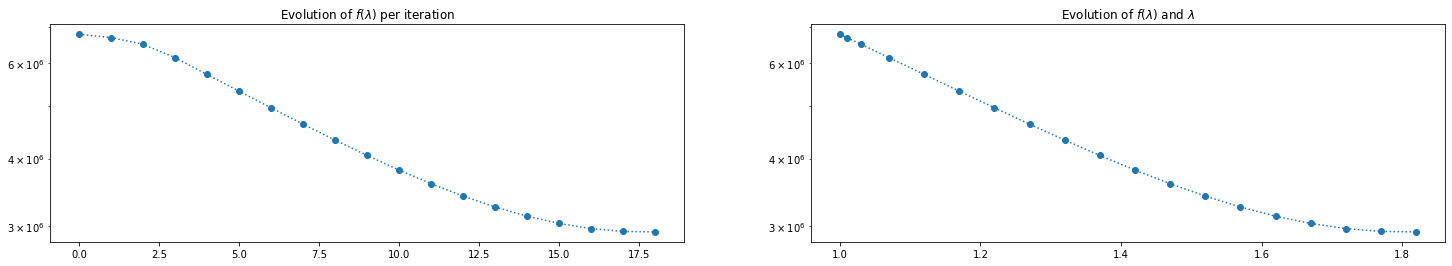

In [94]:
# Plot functional evalations
fig, ax = plt.subplots(1, 2, figsize=(25,4))
ax[0].plot(Obj_Res, 'o:')

ax[1].plot(np.asarray(every_iter['λ']), np.asarray(every_iter['obj']), 'o:')
ax[0].set_yscale('log');    ax[1].set_yscale('log')

ax[0].set_title(r'Evolution of $f(\lambda)$ per iteration')
ax[1].set_title(r'Evolution of $f(\lambda)$ and $\lambda$')

plt.show()

In [96]:
# Just to confirm that indeed the curve is very steep
np.gradient(np.asarray(every_iter['obj']), np.asarray(every_iter['λ']), edge_order=2)

array([-9566509.86627488, -9447661.09396018, -9209963.54929589,
       -8734568.45993911, -8140324.59832056, -7546080.73674915,
       -6951836.87507503, -6357593.01334746, -5763349.15178911,
       -5169105.290202  , -4574861.42852826, -3980617.56689242,
       -3386373.70525408, -2792129.8436484 , -2197885.98202392,
       -1603642.12049931, -1009398.25889546,  -415154.39717712,
         179089.46442455])

A wee recommendation here would be to scale the problem so that $\lambda$ can take larger values.

## As an alternative, let's also run SciPy Optimise:

First let's try one method without using the derivative:

In [78]:
from scipy.optimize import minimize_scalar

In [79]:
start = time.time()
res = minimize_scalar(obj_eval_a, bounds=(Λᵪ[0], Λᵪ[1]), method='bounded', options = {'maxiter':20,'disp':3, 'xatol':1e-10} )
print(res)
end = time.time()
print('{0:.2f}'.format(end-start))

 
 Func-count     x          f(x)          Procedure
    1         1.1459  5.38446e+06        initial
    2         1.8541  2.90663e+06        golden
    3         2.2918  4.41953e+06        golden
    4        1.78821  2.88028e+06        parabolic
    5        1.78821  2.88028e+06        parabolic
    6        1.78818  2.88028e+06        parabolic
    7         1.7882  2.88028e+06        golden
    8        1.78821  2.88028e+06        parabolic
    9        1.78821  2.88028e+06        parabolic
   10        1.78821  2.88028e+06        parabolic
   11        1.78821  2.88028e+06        parabolic
   12        1.78821  2.88028e+06        parabolic
   13        1.78821  2.88028e+06        golden
   14        1.78821  2.88028e+06        golden

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1e-10 )
 message: Solution found.
 success: True
  status: 0
     fun: 2880279.317387219
       x: 1.788213277944243
     nit: 14
    nfev: 14

In [80]:
res.x

1.788213277944243

In [81]:
obj_eval(res.x)

(array(2880279.31743865), array([-859734.07947025]))

In [83]:
# Print final summary
General_SSIM = SSIMG(img, u, M,N,NN)

print('{0:^5s}|{1:^15s}'.format('i','SSIM'))
print('–'*22)
for nn in range(NN):    print('{0:^5d}|{1:^15.8g}'.format(nn, General_SSIM[1][nn] ))
print('–'*22)

  i  |     SSIM      
––––––––––––––––––––––
  0  |  0.62241864   
  1  |  0.58364077   
  2  |  0.63477783   
  3  |  0.64235695   
  4  |  0.52607202   
  5  |  0.55881413   
  6  |  0.61019617   
  7  |  0.64665173   
  8  |  0.61414299   
  9  |  0.57107737   
 10  |  0.64133882   
 11  |  0.62361051   
 12  |  0.60870808   
 13  |  0.54417168   
 14  |  0.57999367   
––––––––––––––––––––––


In [84]:
SSIMG(img, ff, M,N,NN)

(0.5220701675226258,
 array([0.601554  , 0.51840742, 0.48932307, 0.57157184, 0.47812873,
        0.45925629, 0.47952359, 0.55631229, 0.53479609, 0.53890209,
        0.59822707, 0.49251023, 0.53799929, 0.45948854, 0.51505198]))

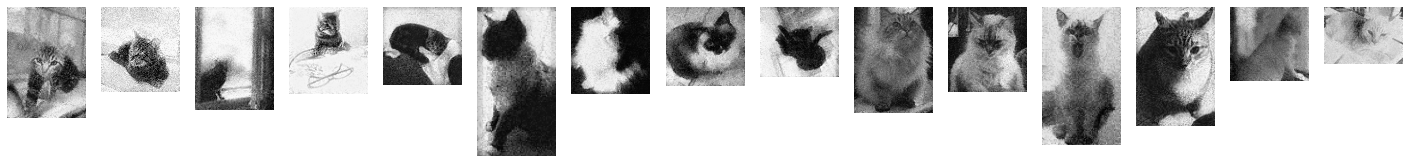

In [85]:
# Application of subblock but projected back
U_ff = [u[ nn].reshape(M[nn],N[nn]) for nn in range(NN)]

fig, ax = plt.subplots(1, NN, figsize=(25,5))

for i in range(NN):
    ax[i].imshow(   U_ff[i], cmap='gray');    ax[i].axis('off');    ax[i].set_anchor('N')
    
fig.subplots_adjust(hspace=0.5)
plt.show()

---

## Results

<div class="alert alert-block alert-info">
    
Here we display the following images:
1. Best objective
3. Original noisy
4. Original image
</div>

In [102]:
obj_eval_a(xₖ.item())

array(2931668.89319212)

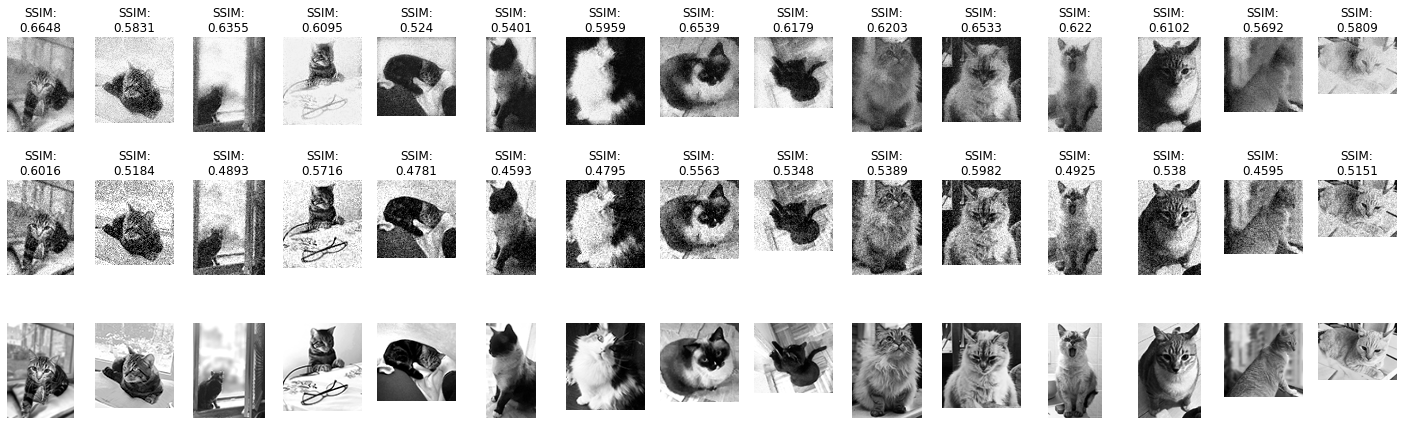

In [103]:
# Application of subblock but projected back
U_ff = [u[nn].reshape(M[nn],N[nn]) for nn in range(NN)]
U_ff = [rescale_intensity(U_ff[nn], out_range='uint8') for nn in range(NN)]
co = SSIMG(img,U_ff, M,N, NN)[1]
cu = SSIMG(img,f, M,N, NN)[1]

fig, ax = plt.subplots(3, NN, figsize=(25,7))

for i in range(NN):
    # Recovered
    ax[0,i].imshow(   U_ff[i], cmap='gray');    ax[0,i].axis('off');    ax[0,i].set_anchor('N');    ax[0,i].set_title('SSIM:\n' + str(around(co[i],4)));
    # Noisy
    ax[1,i].imshow(   f[i], cmap='gray');    ax[1,i].axis('off');    ax[1,i].set_anchor('N');    ax[1,i].set_title('SSIM:\n' + str(around(cu[i],4)));
    # Clean
    ax[2,i].imshow(   img[i], cmap='gray');    ax[2,i].axis('off');    ax[2,i].set_anchor('N');
    
fig.subplots_adjust(hspace=0.5)
plt.show()

In [104]:
print('{0:^5s}|{1:^18s}'.format('i','Unshifted SSIM'))
print('–'*25)
for nn in range(NN):    print('{0:^5d}|{1:^18.11g}'.format(nn, co[nn] ))
print('–'*25)
print('{0:^5s}|{1:^18.11g}'.format('M', np.mean(co) ))

  i  |  Unshifted SSIM  
–––––––––––––––––––––––––
  0  |  0.66476903854   
  1  |  0.58311977717   
  2  |  0.63553412148   
  3  |  0.60946977182   
  4  |  0.52403559309   
  5  |  0.54014833697   
  6  |  0.59589769437   
  7  |  0.65386424057   
  8  |  0.61793085404   
  9  |  0.62033376208   
 10  |  0.65334073178   
 11  |  0.62195762153   
 12  |  0.61024522087   
 13  |   0.5691578345   
 14  |   0.5808676961   
–––––––––––––––––––––––––
  M  |  0.60537815299   


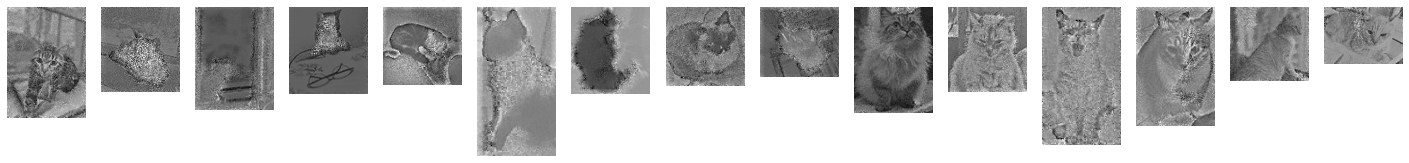

In [105]:
# Plot of adjoints
P_ff = [p[ nn].reshape(M[nn],N[nn]) for nn in range(NN)]

fig, ax = plt.subplots(1, NN, figsize=(25,5))

for i in range(NN):
    ax[i].imshow(   P_ff[i], cmap='gray');    ax[i].axis('off');    ax[i].set_anchor('N')
    
fig.subplots_adjust(hspace=0.5)
plt.show()

Let's also plot the results for the golden section method:

In [86]:
res.x

1.788213277944243

In [87]:
obj_eval_a(1.788213277944243)

array(2880279.31743865)

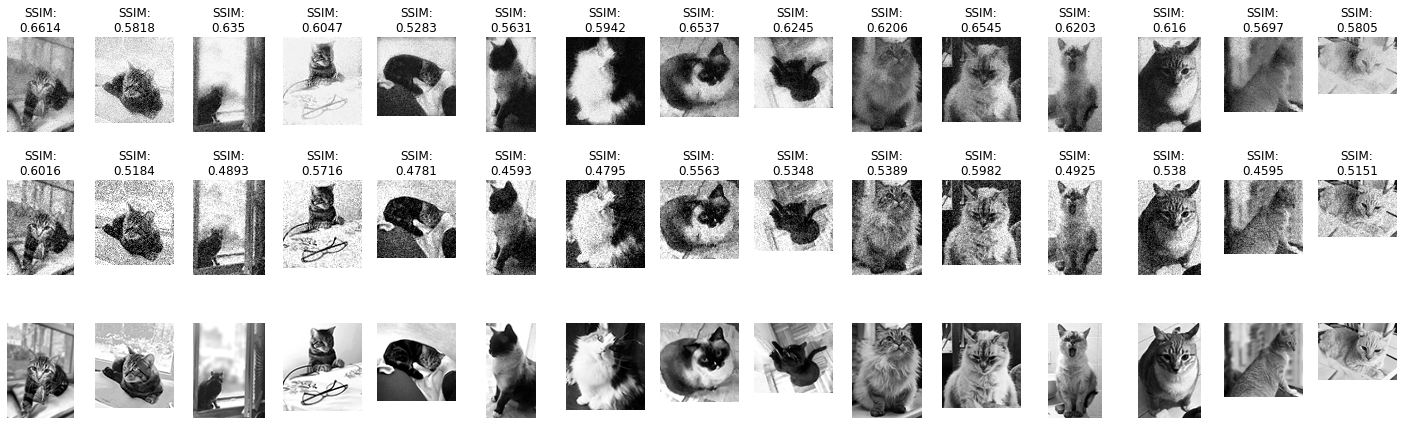

In [88]:
# Application of subblock but projected back
U_ff_g = [u[nn].reshape(M[nn],N[nn]) for nn in range(NN)]
U_ff_g = [rescale_intensity(U_ff_g[nn], out_range='uint8') for nn in range(NN)]
co = SSIMG(img,U_ff_g, M,N, NN)[1]
cu = SSIMG(img,f, M,N, NN)[1]

fig, ax = plt.subplots(3, NN, figsize=(25,7))

for i in range(NN):
    # Recovered
    ax[0,i].imshow(   U_ff_g[i], cmap='gray');    ax[0,i].axis('off');    ax[0,i].set_anchor('N');    ax[0,i].set_title('SSIM:\n' + str(around(co[i],4)));
    # Noisy
    ax[1,i].imshow(   f[i], cmap='gray');    ax[1,i].axis('off');    ax[1,i].set_anchor('N');    ax[1,i].set_title('SSIM:\n' + str(around(cu[i],4)));
    # Clean
    ax[2,i].imshow(   img[i], cmap='gray');    ax[2,i].axis('off');    ax[2,i].set_anchor('N');
    
fig.subplots_adjust(hspace=0.5)
plt.show()

In [89]:
print('{0:^5s}|{1:^18s}'.format('i','Unshifted SSIM'))
print('–'*25)
for nn in range(NN):    print('{0:^5d}|{1:^18.11g}'.format(nn, co[nn] ))
print('–'*25)
print('{0:^5s}|{1:^18.11g}'.format('M', np.mean(co) ))

  i  |  Unshifted SSIM  
–––––––––––––––––––––––––
  0  |  0.66143163823   
  1  |  0.58183646718   
  2  |  0.63503671024   
  3  |  0.60470557474   
  4  |  0.52825586402   
  5  |   0.5631354041   
  6  |  0.59422675252   
  7  |  0.65373099376   
  8  |  0.62453292298   
  9  |  0.62057039927   
 10  |  0.65452735013   
 11  |   0.6202778715   
 12  |   0.6159675736   
 13  |  0.56965735235   
 14  |  0.58049959677   
–––––––––––––––––––––––––
  M  |  0.60722616476   


In [90]:
cu.mean()

0.5220701675226258

<div class="alert alert-block alert-danger">
Output
</div>

In [91]:
folder_Recovered = Path(folder).parent.as_posix() + '/Training_Recovered_PC/'
Path(folder_Recovered).mkdir(parents=True, exist_ok=True)            # Create directory if not already available

In [94]:
Recovered_Names = ['TR_' + '0{}.png'.format(i+1) if i < 9 else 'TR_' + '{}.png'.format(i+1) for i in range(NN)]
[imwrite(folder_Recovered + Recovered_Names[nn], U_ff_g[nn]) for nn in range(NN)];

# Validation with testing set

<div class="alert alert-block alert-danger">
To reduce memory requirements, the following will overwrite some of the structures built before in the notebook. This is due to the independence of the inputs: the new data is not assumed to be of the same shape as the training data, hence new kernels and windows are needed. 
</div>

In [95]:
res.x

1.788213277944243

In [96]:
λ = 1.788213277944243
σ = 40.0

<div class="alert alert-block alert-info">
We load the validation data base which has two subsets:

<b>a.</b> A clean images dataset, and
    
<b>b.</b> A noisy images dataset.
</div>

In [97]:
folder_Validation_C = Path(folder).parent.as_posix() + '/Validation_Clean/'
folder_Validation_N = Path(folder).parent.as_posix() + '/Validation_Noisy/'

In [98]:
# Read clean images
img = imread_collection( folder_Validation_C + '/*.png', conserve_memory = False)       # Image read
img  = asarray([255 * img_as_float(rescale_intensity(i, out_range='uint8')) for i in img])
M, N = asarray([i.shape for i in img]).T                                    # Store image sizes

NN  = len(img)                                                              # training set size
print('{0} images with average size (M̅ᵥ,N̅ᵥ) = ({1},{2})'.format(NN, M.mean().astype(int), N.mean().astype(int) ))

11 images with average size (M̅ᵥ,N̅ᵥ) = (97,96)


In [99]:
# Read noisy images
f = imread_collection( folder_Validation_N + '/*.png', conserve_memory = False)       # Image read
f = asarray([255 * img_as_float(rescale_intensity(i, out_range='uint8')) for i in f])

if f.shape[0] != NN:
    print('Error: The number of images read is different than the number of images in the dataset.')
else:
    print(NN, 'images read.')

11 images read.


Display images

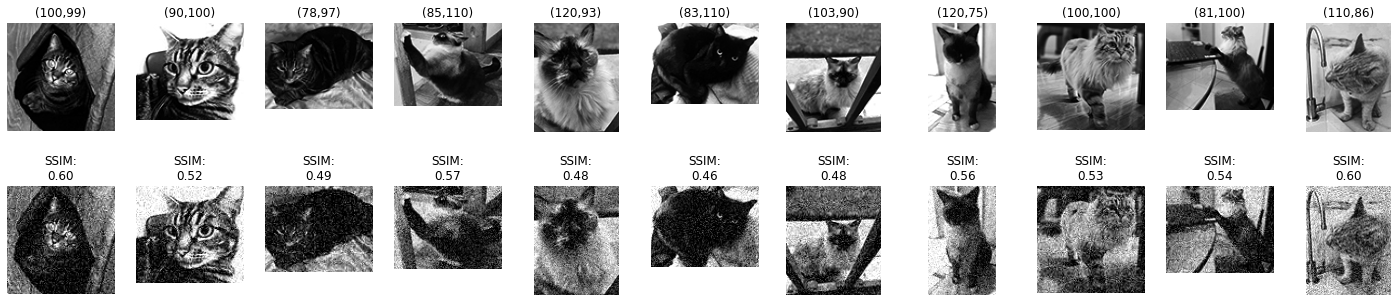

In [100]:
# Clean and noisy images: title is M × N

fig, ax = plt.subplots(2, NN, figsize=(25,5))

for i in range(NN):
    ax[0,i].imshow( img[i], cmap='gray')
    ax[0,i].set_title('({0},{1})'.format(M[i],N[i]));    ax[0,i].axis('off');    ax[0,i].set_anchor('N')
    
    ax[1,i].imshow( f[i], cmap='gray')
    ax[1,i].set_title('SSIM:\n{0:.2f}'.format(Quality[1][i]));    ax[1,i].axis('off');    ax[1,i].set_anchor('N')
    
fig.subplots_adjust(hspace=0.5)
plt.show()

<div class="alert alert-block alert-warning">
New kernels are needed:
</div>

In [101]:
num_windows = np.empty(NN, dtype=int)
k_weight    = np.empty(NN)
Sub_Γℓ = []

print('–'*60)
for nn in range(NN):
    print('id: {0}'.format(nn))
    nm  = M[nn] * N[nn]
    ram_size = np.float64(1).itemsize * np.prod([nm,nm]) / (1024 ** 3)
    print( ' Mᵢ, Nᵢ, Mᵢ×Nᵢ, Γℓ[GB]:  {0:3d},  {1:3d},  {2:5d},  {3:7.2f}'.format(M[nn], N[nn], nm, ram_size) )
    print( ' SSIM:' + 16*' ' + '{0:.2f}'.format( Quality[1][nn]  ))
    
    '''
        Kernel Setup
    '''
    Fᵖᵃᵈ = pad(f[nn], ρ, mode='constant')
    X = sliding_window_view(Fᵖᵃᵈ, (ρ̂,ρ̂)).reshape(nm, ρ̂**2)
    
    '''Build windows'''
    start = time.time()
    # determine windows of features by their mis
    res_idx = clf.make_mi_scores(X, around(f[nn]).astype(int).ravel())
    windows = clf.get_mis_windows(res_idx)
    num_windows[nn] = len(windows)
    end = time.time()
    print( ' Windows:' + 13*' ' + '{0:d} ({1:.2f} s)'.format( num_windows[nn], end-start ))
    
    '''Weights'''
    # Compute kernel weights: equal weights that sup up to 1 or no weighting:
    k_weight[nn] = 1.0/num_windows[nn]
    
    '''Kernel as abstract object'''
    def W(σ, n = 64, m = 8, p = 8, Other_Setup = None):
        '''
        Set up the subkernel matrices that constitute the extended Gaussian ANOVA kernel

        Note
        ----
        Using the NFFT-approach, the kernel matrices are never computed explicitly.

        Parameters
        ----------
        X : ndarray
            The training data matrix.
        σ : float
            Shape of the kernel.
        n : even int
            The NFFT expansion degree.
        m : int ≤ max(N,M)
            Window cutoff.
        p : int
            Smoothness of the window function.

        Returns
        -------
        SubKernels : list of fastadj.AdjacencyMatrix
            Subkernel matrices for each window of features according to the selected window scheme.
        '''

        # Bound on window cutoff [Lemma 3.4]
        if n < max([4*m,12]):
            print('Changing n = {} to {}'.format(n, max([4*m,12])))
            n = max([4*m,12])

        # Setup approximation parameters
        NFFT_setup = fastadj.AccuracySetup(n,m,p,0,0)   if Other_Setup is None else   Other_Setup

        # Set diagonal → 0, since FastAdjacency package is targeted at graph Laplacian with zeros at the diagonal
        return [fastadj.AdjacencyMatrix(X[:,windows[l]], σ, NFFT_setup, 0.0) for l in range(num_windows[nn])]
    
    start = time.time()
    Sub_Γℓ.append( W(σ, Other_Setup = 'default') )
    end = time.time()
    print(' Setup:' + 15*' ' + '{0:.2f} s'.format( end - start ))
    
    print('–'*60)

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
id: 0
 Mᵢ, Nᵢ, Mᵢ×Nᵢ, Γℓ[GB]:  100,   99,   9900,     0.73
 SSIM:                0.60
 Windows:             41 (12.90 s)
 Setup:               0.43 s
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
id: 1
 Mᵢ, Nᵢ, Mᵢ×Nᵢ, Γℓ[GB]:   90,  100,   9000,     0.60
 SSIM:                0.52
 Windows:             41 (10.74 s)
 Setup:               0.27 s
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
id: 2
 Mᵢ, Nᵢ, Mᵢ×Nᵢ, Γℓ[GB]:   78,   97,   7566,     0.43
 SSIM:                0.49
 Windows:             41 (13.22 s)
 Setup:               0.24 s
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
id: 3
 Mᵢ, Nᵢ, Mᵢ×Nᵢ, Γℓ[GB]:   85,  110,   9350,     0.65
 SSIM:                0.57
 Windows:             41 (11.34 s)
 Setup:               0.29 s
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
id: 4
 Mᵢ, Nᵢ, Mᵢ×Nᵢ, Γℓ[GB]:  120,   93,  11160,     0.93
 SSIM:                0.48
 Windows:

In [102]:
nm   = np.prod([M,N],0).sum()                  # Total problem size
nm_s = np.prod([M,N],0)                        # Particular sizes
cuts = np.r_[0,np.cumsum(np.prod([M,N],0))]    # Indices to identify each subblock
# Check with [np.count_nonzero(np.concatenate(η)[ cuts[nn]:cuts[nn+1] ] - η[nn]) for nn in range(NN)]

In [103]:
Ones = [ones(M[nn] * N[nn]) for nn in range(NN)]

In [104]:
# Function to be executed in parallel
def compute_vector(nn, l, u):
    """Apply the function Sub_Γℓ[nn][l] to u[nn]"""
    #return funs[nn][l](u)
    return Sub_Γℓ[nn][l].apply(u)

In [105]:
def AK_n(nn):
    # Outer function selects the index nn and prepares the evaluator
    results = empty([num_windows[nn], nm_s[nn]])        # Initialize a structure to hold the results
    def AK(u):
        nonlocal nn  # Declare that nn is not a local variable
        """
        Approximate the matrix-vector product AK*u, where AK = w * (K_1 + K_2 + ... + K_L).

        Note
        ----
        Since this function serves a LinearOperator from scipy, only one variable can be passed as input parameter.
        Any other variable needed has to be global, so that they can still be used within this function

        Parameters
        ----------
        u : ndarray
            The vector, whose product AK*u with the matrix AK shall be approximated.

        Returns
        -------
        AKu : ndarray
            The approximated matrix-vector product AK*u.
        """
        
        # Apply matrix-vector multiplication in parallel
        with ProcessPoolExecutor(max_workers=8, mp_context=mp_fork) as executor:
            # Create all possible (nn, l) pairs and execute them in parallel
            futures = {executor.submit(compute_vector, nn, l, u): (nn, l) for l in range(num_windows[nn])}

            # Collect the results as they complete
            for future in concurrent.futures.as_completed(futures):
                nn, l = futures[future]
                try:
                    results[l] = future.result()
                except Exception as e:
                    print(f"An error occurred at (nn={nn}, l={l}): {e}")
        
        # Add up products and weight
        AKu = results.sum(0) * k_weight[nn]
        
        return AKu
    return AK

In [106]:
AKs = [AK_n(nn) for nn in range(NN)]

In [107]:
start = time.time()
η = [AKs[nn](Ones[nn]) for nn in range(NN)]
end = time.time()
print('Parallel application - 8: {0:.2f} s'.format( end - start ))

Parallel application - 8: 3.88 s


In [108]:
print('–'*80)
for nn in range(NN):
    print('id: {0:2d} – '.format(nn), end = '')
    nm  = M[nn] * N[nn]
    ram_size = np.float64(1).itemsize * np.prod([nm,nm]) / (1024 ** 3)
    print( '(Γℓ)_ℓ: {0:6.2f} [GB] – '.format(ram_size * num_windows[nn]), end = '' )
    # Approximate numerical range
    E_A = μ * η[nn].max()
    e_A = μ * η[nn].min() * nm/(nm-1)
    print('Ŵᶠᵃˢᵗ(B) - {0}:' +  7*' ' + '{0:5.2f}  {1:8.2e}'.format( E_A, e_A ) )
    print('–'*80)

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
id:  0 – (Γℓ)_ℓ:  29.94 [GB] – Ŵᶠᵃˢᵗ(B) - {0}:       16.47  7.98e-01
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
id:  1 – (Γℓ)_ℓ:  24.74 [GB] – Ŵᶠᵃˢᵗ(B) - {0}:        7.60  9.89e-01
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
id:  2 – (Γℓ)_ℓ:  17.49 [GB] – Ŵᶠᵃˢᵗ(B) - {0}:       15.93  6.44e-01
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
id:  3 – (Γℓ)_ℓ:  26.71 [GB] – Ŵᶠᵃˢᵗ(B) - {0}:       11.93  7.62e-01
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
id:  4 – (Γℓ)_ℓ:  38.05 [GB] – Ŵᶠᵃˢᵗ(B) - {0}:        7.10  1.63e+00
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
id:  5 – (Γℓ)_ℓ:  25.46 [GB] – Ŵᶠᵃˢᵗ(B) - {0}:       22.24  4.62e-01
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
id:  6 – (Γℓ)_ℓ:  2

In [109]:
A = [LinearOperator((nm_s[nn],nm_s[nn]), dtype=np.float64, matvec=MatVecs(nn), rmatvec=MatVecs(nn)) for nn in range(NN)]

In [110]:
uT = asarray([i.flatten() for i in img])    # Flatten clean images
ff = asarray([i.flatten() for i in f])      # Flatten noisy samples

In [111]:
A[nn](Ones[nn])

array([1.78821328, 1.78821328, 1.78821328, ..., 1.78821328, 1.78821328,
       1.78821328])

In [112]:
# Basis change only depends on the dimension of each image, so we only have to define it once
not_e_1 = [ones(nm_s[nn]) for nn in range(NN)]
[setitem(not_e_1[nn], 0 , 0.0) for nn in range(NN)];

aux_h = [np.arange(nm_s[nn]) for nn in range(NN)]
aux_d = [np.reciprocal(np.sqrt( np.concatenate( ([nm_s[nn]], np.arange(2,nm_s[nn]+1) * np.arange(1,nm_s[nn]) ) ) ))  for nn in range(NN)]

In [113]:
def MV_basis_U_T(v, nn):
    '''
        Transpose of unitary transformation
    '''
    v = v if isinstance(v, np.ndarray) else asarray(v)    # Ensure an ndim array is given
            
    # We iteratively apply U.T to each slice
    U_T_v = aux_d[nn] * (np.roll( np.cumsum(v),1) - (aux_h[nn] * v))
    
    return asarray(U_T_v)

In [114]:
def MV_basis_U(v, nn):
    '''
        Unitary transformation
    '''
    v = v if isinstance(v, np.ndarray) else asarray(v)    # Ensure an ndim array is given
        
    # We iteratively apply U to each slice
    w   = aux_d[nn] * v
    U_v = ((w.sum() - np.cumsum(w)) * np.flip(not_e_1[nn])) - (aux_h[nn] * w) + w[0]
    
    return asarray(U_v)

In [115]:
all([allclose(MV_basis_U_T( MV_basis_U(Ones[nn],nn), nn), 1) for nn in range(NN)])

True

In [116]:
# Projections
Prec_RHS = asarray([MV_basis_U_T(ff[nn],nn) for nn in range(NN)])

In [117]:
# Define subblock of system
def MAM_op(nn):
    # Define matrix vector multiplications for a choice of nn
    def MV_basis_MAM(v):
        nonlocal nn
        '''
            Project back v, change basis by U, apply A, then U.T, and project; i.e., (P U.T A U) P.T v
        '''
        w = np.concatenate( ([0.0], v) )
        w = MV_basis_U_T( A[nn].dot( MV_basis_U( w, nn ) ), nn )
        return w[1:]

    return MV_basis_MAM

In [118]:
MAM = [LinearOperator((nm_s[nn]-1,nm_s[nn]-1), dtype=np.float64, matvec=MAM_op(nn), rmatvec=MAM_op(nn)) for nn in range(NN)]

In [119]:
Vs = zeros(nm_s[nn]);    Vs[0] = 1.0
allclose(MV_basis_U_T(  A[nn].dot(MV_basis_U( Vs, nn )), nn), λ*Vs)

True

In [120]:
# Define sub preconditioners
def UDU_op(nn):
    # Define matrix vector multiplications for a choice of nn
    def Proj_Prec_Diag(v):
        nonlocal nn
        '''
            Project back v, change basis by U, apply M, then U.T, and project; i.e., (P U.T A U) P.T v
        '''
        w = np.concatenate( ([0.0], v) )
        w = MV_basis_U_T( diag_P[nn] * MV_basis_U(w,nn), nn )
        return w[1:]

    return Proj_Prec_Diag

In [121]:
UDU = [LinearOperator((nm_s[nn]-1,nm_s[nn]-1), dtype=np.float64, matvec=UDU_op(nn), rmatvec=UDU_op(nn)) for nn in range(NN)]

In [122]:
η = asarray(η)

In [123]:
diag_P = η**-1    # Example for test

<div class="alert alert-block alert-info">
Evaluate objective:
</div>

In [124]:
u = asarray([i.copy() for i in ff])

In [125]:
def obj_eval_v(λ):                  # ** Eval f ** #
    global u,   diag_P,   g_cg_it, cg_its
    '''
        Evaluate state and return objective
    '''
    if λ < 0.0:        return 4*Snorm(u) + 1e+4    # In case something goes off, penalise negative values of λ
    
    # Build simple diagonal preconditioner [don't forget about μ]
    add(μ * η, λ, out = diag_P);    reciprocal(diag_P, out = diag_P);
    
    Prec_x_0 = asarray([MV_basis_U_T(u[nn],nn) for nn in range(NN)]) / λ     # Project initial solution
    
    cg_its = []
    for nn in range(NN):
        '''    State u    '''
        ## MAM x = g / s  ->  [sx] solves MAM uₒ = g, in particular we could take s = ‖g‖
        s = norm(Prec_RHS[nn][1:])
        g_cg_it = 0
        uₒ, status = cg(MAM[nn], Prec_RHS[nn][1:]/s, x0 = Prec_x_0[nn][1:]/s, tol = 1e-10, maxiter = 25, M = UDU[nn], callback = solver_call)
        uₒ *= s
        #print( '{0:.2e} {1:.2e}'.format( norm(MAM[nn](uₒ) - Prec_RHS[nn][1:]), norm(MAM[nn](uₒ) - Prec_RHS[nn][1:])/norm( Prec_RHS[nn][1:] ) ))

        # Build solution out of blocks
        u[nn][1:] = λ * uₒ                   # Second block
        u[nn][0]  = Prec_RHS[nn][0].copy()   # First subblock
        u[nn] = MV_basis_U(u[nn],nn)         # Go back to original basis
    
        cg_its.append(g_cg_it)
        
    return array(Objective(u))

In [126]:
# Evaluate before getting results
obj_eval_v(λ).item()

6550819.707592973

<div class="alert alert-block alert-info">
    
Here we display the following images:
1. Recovered image
3. Original noisy
4. Original image
</div>

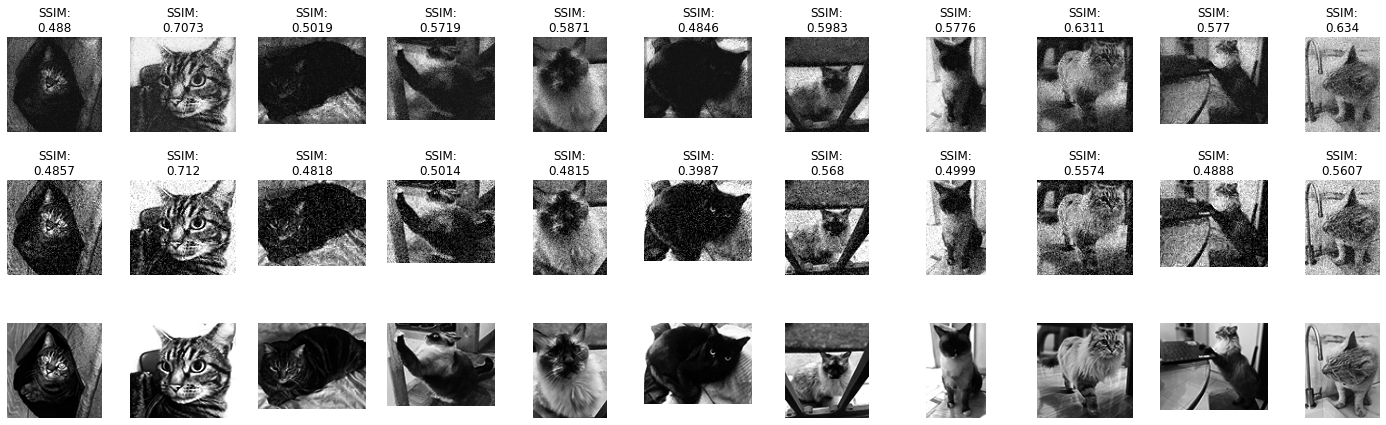

In [127]:
# Comparison of results
U_ff = [u[nn].reshape(M[nn],N[nn]) for nn in range(NN)]
U_ff = [rescale_intensity(U_ff[nn], out_range='uint8') for nn in range(NN)]
co = SSIMG(img,U_ff, M,N, NN)[1]
cu = SSIMG(img,f, M,N, NN)[1]

fig, ax = plt.subplots(3, NN, figsize=(25,7))

for i in range(NN):
    # Recovered
    ax[0,i].imshow(   U_ff[i], cmap='gray');    ax[0,i].axis('off');    ax[0,i].set_anchor('N');    ax[0,i].set_title('SSIM:\n' + str(around(co[i],4)));
    # Noisy
    ax[1,i].imshow(   f[i], cmap='gray');    ax[1,i].axis('off');    ax[1,i].set_anchor('N');    ax[1,i].set_title('SSIM:\n' + str(around(cu[i],4)));
    # Clean
    ax[2,i].imshow(   img[i], cmap='gray');    ax[2,i].axis('off');    ax[2,i].set_anchor('N');
    
fig.subplots_adjust(hspace=0.5)
plt.show()

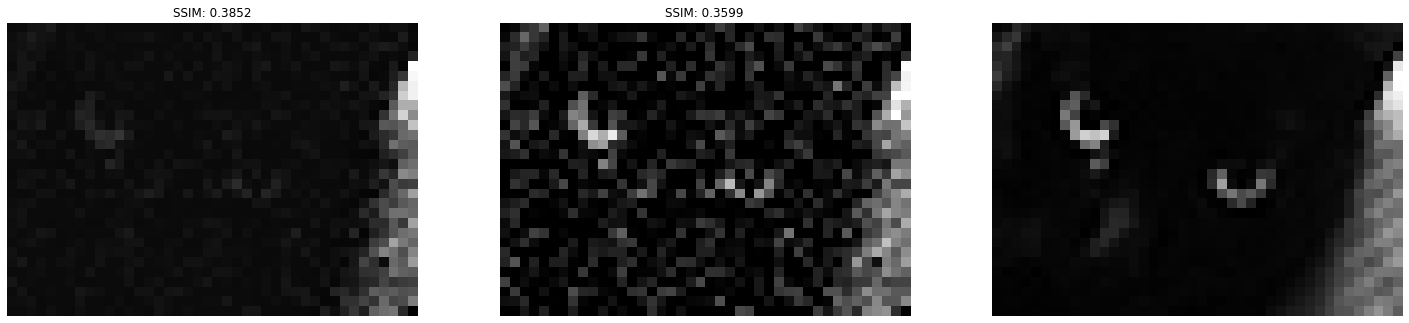

In [128]:
# Example
fig, ax = plt.subplots(1, 3, figsize=(25,7))

sub_cat_R = U_ff[5].reshape([M[5], N[5]])[20:50,-50:-8]
sub_cat_N = ff[5].reshape([M[5], N[5]])[20:50,-50:-8]
sub_cat_C = img[5].reshape([M[5], N[5]])[20:50,-50:-8]

ax[0].imshow(sub_cat_R, cmap='gray')
ax[1].imshow(sub_cat_N, cmap='gray')
ax[2].imshow(sub_cat_C, cmap='gray')

ax[0].set_title('SSIM: {0:.4f}'.format(SSIM(sub_cat_C, sub_cat_R, sub_cat_N.shape[0], sub_cat_N.shape[1]) ))
ax[1].set_title('SSIM: {0:.4f}'.format(SSIM(sub_cat_C, sub_cat_N, sub_cat_N.shape[0], sub_cat_N.shape[1]) ))

ax[0].axis('off');ax[1].axis('off');ax[2].axis('off');

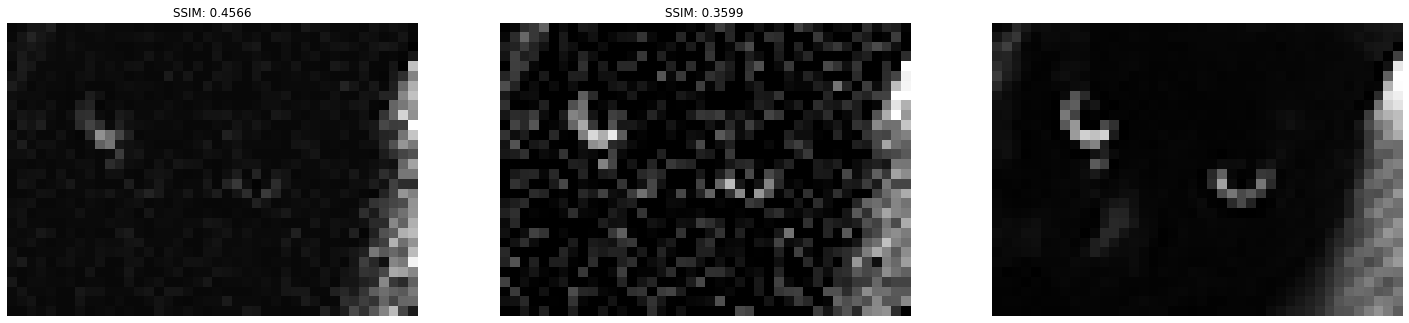

In [337]:
# Example from previous experiment
fig, ax = plt.subplots(1, 3, figsize=(25,7))

sub_cat_R = U_ff[5].reshape([M[5], N[5]])[20:50,-50:-8]
sub_cat_N = ff[5].reshape([M[5], N[5]])[20:50,-50:-8]
sub_cat_C = img[5].reshape([M[5], N[5]])[20:50,-50:-8]

ax[0].imshow(sub_cat_R, cmap='gray')
ax[1].imshow(sub_cat_N, cmap='gray')
ax[2].imshow(sub_cat_C, cmap='gray')

ax[0].set_title('SSIM: {0:.4f}'.format(SSIM(sub_cat_C, sub_cat_R, sub_cat_N.shape[0], sub_cat_N.shape[1]) ))
ax[1].set_title('SSIM: {0:.4f}'.format(SSIM(sub_cat_C, sub_cat_N, sub_cat_N.shape[0], sub_cat_N.shape[1]) ))

ax[0].axis('off');ax[1].axis('off');ax[2].axis('off');

In [129]:
print('{0:^5s}|{1:^18s}'.format('i','Unshifted SSIM'))
print('–'*25)
for nn in range(NN):    print('{0:^5d}|{1:^18.11g}'.format(nn, co[nn] ))
print('–'*25)
print('{0:^5s}|{1:^18.11g}'.format('M', np.mean(co) ))

  i  |  Unshifted SSIM  
–––––––––––––––––––––––––
  0  |  0.48795815285   
  1  |  0.70725237625   
  2  |  0.50191202167   
  3  |  0.57186739063   
  4  |  0.58710472186   
  5  |   0.4846296664   
  6  |  0.59831353392   
  7  |  0.57761677451   
  8  |  0.63112622803   
  9  |  0.57703036207   
 10  |  0.63404233292   
–––––––––––––––––––––––––
  M  |  0.57807759646   


In [287]:
print('{0:^5s}|{1:^18s}'.format('i','Unshifted SSIM'))
print('–'*25)
for nn in range(NN):    print('{0:^5d}|{1:^18.11g}'.format(nn, co[nn] ))
print('–'*25)
print('{0:^5s}|{1:^18.11g}'.format('M', np.mean(co) ))

  i  |  Unshifted SSIM  
–––––––––––––––––––––––––
  0  |  0.45506854042   
  1  |   0.6705306295   
  2  |  0.53322261961   
  3  |  0.54795375598   
  4  |  0.55265736597   
  5  |  0.57844947262   
  6  |  0.56818922057   
  7  |  0.56378061364   
  8  |  0.58666436268   
  9  |  0.55198182084   
 10  |  0.60081778433   
–––––––––––––––––––––––––
  M  |  0.56448328965   


In [130]:
cu.mean()

0.5214479184900557

<div class="alert alert-block alert-danger">
Output
</div>

In [131]:
folder_Recovered = Path(folder).parent.as_posix() + '/Validation_Recovered_PC/'
Path(folder_Recovered).mkdir(parents=True, exist_ok=True)            # Create directory if not already available

In [132]:
Recovered_Names = ['VR_' + '0{}.png'.format(i+1) if i < 9 else 'VR_' + '{}.png'.format(i+1) for i in range(NN)]
[imwrite(folder_Recovered + Recovered_Names[nn], U_ff[nn].astype(np.uint8)) for nn in range(NN)];

---

# Other

## Shared memory test

Little test of memory:

In [116]:
rng = default_rng(10)
Z = rng.normal(0, 1, [30,3])

In [117]:
def W(σ, n = 64, m = 8, p = 8, Other_Setup = None):
    # Setup approximation parameters
    NFFT_setup = fastadj.AccuracySetup(n,m,p,0,0)   if Other_Setup is None else   Other_Setup
    return [fastadj.AdjacencyMatrix(Z, σ, NFFT_setup, 0.0) for l in range(2)]

def AK(u):
    # Apply matrix-vector multiplication
    AKu = np.zeros_like(u)
    for l in range(2):
        AKu += SubKernels[l].apply(u)
    # Multiply each subKernel by its weight and collect into a sum
    AKu *= 0.5
    return AKu

In [118]:
SubKernels = W(σ, Other_Setup = 'fine')

In [119]:
AK(ones(30))

array([28.88670667, 28.91892454, 28.83752897, 28.91410322, 28.91855006,
       28.81735135, 28.90619944, 28.85331717, 28.84474194, 28.80646189,
       28.83609118, 28.80397848, 28.88742006, 28.92211151, 28.88883769,
       28.84519289, 28.88707701, 28.91959674, 28.76553612, 28.91875104,
       28.88151133, 28.77101363, 28.92207385, 28.87849062, 28.9087072 ,
       28.86684557, 28.92280579, 28.91753665, 28.70298851, 28.81351775])

In [120]:
Mat_NFST  = np.apply_along_axis(SubKernels[0].apply, 0, np.eye(30))
Mat_NFST += np.apply_along_axis(SubKernels[1].apply, 0, np.eye(30))
Mat_NFST *= 0.5

In [121]:
np.fill_diagonal(Mat_NFST, 1.0) # Just for checking visually

Let's modify ```Z``` and see if the matrix changes:

In [123]:
Z = 2 * rng.normal(0, 1, [30,3])

First we can check that the final degree vector does not change:

In [124]:
AK(ones(30))

array([28.88670667, 28.91892454, 28.83752897, 28.91410322, 28.91855006,
       28.81735135, 28.90619944, 28.85331717, 28.84474194, 28.80646189,
       28.83609118, 28.80397848, 28.88742006, 28.92211151, 28.88883769,
       28.84519289, 28.88707701, 28.91959674, 28.76553612, 28.91875104,
       28.88151133, 28.77101363, 28.92207385, 28.87849062, 28.9087072 ,
       28.86684557, 28.92280579, 28.91753665, 28.70298851, 28.81351775])

Now let's obtain the intermediate kernels explicitly and assemble the matrix:

In [125]:
bMat_NFST  = np.apply_along_axis(SubKernels[0].apply, 0, np.eye(30))
bMat_NFST += np.apply_along_axis(SubKernels[1].apply, 0, np.eye(30))
bMat_NFST *= 0.5
np.fill_diagonal(bMat_NFST, 1.0) # Just for checking visually

In [126]:
np.count_nonzero(bMat_NFST-Mat_NFST)

0

Ok, the memory is not shared through ```Z```. Now let's repeat it through a list just to be extra sure:

In [127]:
Sub_Γℓ = [SubKernels, None]

In [128]:
def AK_n(nn):
    def AK(u):
        # Apply matrix-vector multiplication
        AKu = np.zeros_like(u)
        for l in range(2):
            AKu += Sub_Γℓ[nn][l].apply(u)
        # Multiply each subKernel by its weight and collect into a sum
        AKu *= 0.5
        return AKu
    return AK

In [129]:
Sub_Γℓ[1] = W(σ, Other_Setup = 'fine')     # Created with the new Z

In [130]:
AKs = [AK_n(nn) for nn in range(2)]

In [131]:
AKs[0](ones(30)), AKs[1](ones(30))

(array([28.88670667, 28.91892454, 28.83752897, 28.91410322, 28.91855006,
        28.81735135, 28.90619944, 28.85331717, 28.84474194, 28.80646189,
        28.83609118, 28.80397848, 28.88742006, 28.92211151, 28.88883769,
        28.84519289, 28.88707701, 28.91959674, 28.76553612, 28.91875104,
        28.88151133, 28.77101363, 28.92207385, 28.87849062, 28.9087072 ,
        28.86684557, 28.92280579, 28.91753665, 28.70298851, 28.81351775]),
 array([28.38383547, 28.53096327, 27.9903928 , 28.16730769, 28.36223936,
        28.17538931, 28.42809806, 27.60817825, 28.10744958, 28.02949951,
        27.79640521, 28.43166307, 28.16155282, 27.8923602 , 28.35373057,
        28.30820589, 28.43129605, 28.43463205, 28.31047252, 27.86731509,
        27.85331211, 28.52534351, 28.00514614, 27.87570056, 28.34103648,
        27.86136485, 27.51789082, 28.05521782, 27.62156488, 28.47901169]))

Since ```AK``` depended on ```SubKernels```, it was sharing memory, so we implemented a function that processes the matrix vector multiplication separatedly after each subkernel has been defined properly in memory.

## Parallelising the matrix vector multiplication

Below we implement the operation $ \left( \sum\limits_{\ell=1}^{\mathsf{L}} \Gamma_{\ell,i} u_{i} \right)_{i \in 1:N}$ in parallel.

### First, we parallelise $ \left( \Gamma_{\ell,i} u_{i} \right)_{\ell \in 1:\mathsf{L}, i \in 1:N}$:

The following configuration is needed for preventing issues with the parallel library and MacOs:

In [28]:
import concurrent.futures
from concurrent.futures import ProcessPoolExecutor
import multiprocessing as mp                                                                                     
mp.set_start_method("fork")
mp_fork = mp.get_context('fork')

In [22]:
Ones = [ones(M[nn] * N[nn]) for nn in range(NN)]

In [43]:
# Function to be executed in parallel
def compute_vector(nn, l, u):
    """Apply the function Sub_Γℓ[nn][l] to u[nn]"""
    #return funs[nn][l](u)
    return Sub_Γℓ[nn][l].apply(u)

In [34]:
funs = [[sum for l in range(num_windows[nn])] for nn in range(NN)]

In [35]:
# Initialize a structure to hold the results
results = [[None for l in range(num_windows[nn])] for nn in range(NN)]

In [44]:
with concurrent.futures.ProcessPoolExecutor(max_workers=1, mp_context=mp_fork) as executor:
    # Create all possible (nn, l) pairs and execute them in parallel
    future_to_indices = {executor.submit(compute_vector, nn, l, Ones[nn]): (nn, l) for nn in range(NN) for l in range(num_windows[nn])}
    
    # Collect the results as they complete
    for future in concurrent.futures.as_completed(future_to_indices):
        nn, l = future_to_indices[future]
        try:
            results[nn][l] = future.result()
        except Exception as e:
            print(f"An error occurred at (nn={nn}, l={l}): {e}")

In [60]:
results = asarray([np.sum(results[nn], 0) * k_weight[nn] for nn in range(NN)])

In [68]:
[np.count_nonzero((results - η)[nn]) for nn in range(NN)]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

That test was serial, let's divide:

In [83]:
start = time.time()

# Initialize a structure to hold the results
results = [[None for l in range(num_windows[nn])] for nn in range(NN)]
with concurrent.futures.ProcessPoolExecutor(max_workers=2, mp_context=mp_fork) as executor:
    # Create all possible (nn, l) pairs and execute them in parallel
    future_to_indices = {executor.submit(compute_vector, nn, l, Ones[nn]): (nn, l) for nn in range(NN) for l in range(num_windows[nn])}
    
    # Collect the results as they complete
    for future in concurrent.futures.as_completed(future_to_indices):
        nn, l = future_to_indices[future]
        try:
            results[nn][l] = future.result()
        except Exception as e:
            print(f"An error occurred at (nn={nn}, l={l}): {e}")

end = time.time()
print('Parallel application - 2: {0:.2f} s'.format( end - start ))

# Again:

start = time.time()
# Initialize a structure to hold the results
results = [[None for l in range(num_windows[nn])] for nn in range(NN)]
with concurrent.futures.ProcessPoolExecutor(max_workers=3, mp_context=mp_fork) as executor:
    # Create all possible (nn, l) pairs and execute them in parallel
    future_to_indices = {executor.submit(compute_vector, nn, l, Ones[nn]): (nn, l) for nn in range(NN) for l in range(num_windows[nn])}
    
    # Collect the results as they complete
    for future in concurrent.futures.as_completed(future_to_indices):
        nn, l = future_to_indices[future]
        try:
            results[nn][l] = future.result()
        except Exception as e:
            print(f"An error occurred at (nn={nn}, l={l}): {e}")

end = time.time()
print('Parallel application - 3: {0:.2f} s'.format( end - start ))

# Once more

start = time.time()
# Initialize a structure to hold the results
results = [[None for l in range(num_windows[nn])] for nn in range(NN)]
with concurrent.futures.ProcessPoolExecutor(max_workers=8, mp_context=mp_fork) as executor:
    # Create all possible (nn, l) pairs and execute them in parallel
    future_to_indices = {executor.submit(compute_vector, nn, l, Ones[nn]): (nn, l) for nn in range(NN) for l in range(num_windows[nn])}
    
    # Collect the results as they complete
    for future in concurrent.futures.as_completed(future_to_indices):
        nn, l = future_to_indices[future]
        try:
            results[nn][l] = future.result()
        except Exception as e:
            print(f"An error occurred at (nn={nn}, l={l}): {e}")

end = time.time()
print('Parallel application - 8: {0:.2f} s'.format( end - start ))

# One last time but with the number of images

start = time.time()
# Initialize a structure to hold the results
results = [[None for l in range(num_windows[nn])] for nn in range(NN)]
with concurrent.futures.ProcessPoolExecutor(max_workers=15, mp_context=mp_fork) as executor:
    # Create all possible (nn, l) pairs and execute them in parallel
    future_to_indices = {executor.submit(compute_vector, nn, l, Ones[nn]): (nn, l) for nn in range(NN) for l in range(num_windows[nn])}
    
    # Collect the results as they complete
    for future in concurrent.futures.as_completed(future_to_indices):
        nn, l = future_to_indices[future]
        try:
            results[nn][l] = future.result()
        except Exception as e:
            print(f"An error occurred at (nn={nn}, l={l}): {e}")

end = time.time()
print('Parallel application - 15: {0:.2f} s'.format( end - start ))

Parallel application - 2: 4.45 s
Parallel application - 3: 2.54 s
Parallel application - 8: 1.43 s
Parallel application - 15: 1.52 s


In [80]:
results = asarray([np.sum(results[nn], 0) * k_weight[nn] for nn in range(NN)])
[np.count_nonzero((results - η)[nn]) for nn in range(NN)]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

We know we can reduce things down to less than a second because:

In [133]:
start = time.time()
[AKs[nn]( ones(M[nn] * N[nn]) ) for nn in [0]]
end = time.time()
print('One kernel in sequential application: {0:.2f} s'.format( end - start ))

start = time.time()
[Sub_Γℓ[nn][0].apply( ones(M[nn] * N[nn]) ) for nn in [0]]
end = time.time()
print('One subkernel application: {0:.2f} s'.format( end - start ))

One kernel in sequential application: 0.48 s
One subkernel application: 0.03 s


We currently cannot reach this time due to computational constraints. If we had a machine with $N\times \mathsf{L}$ cores, we would be able to reduce the time to just one matrix vector multiplication; i.e., 0.03 s. With $\mathsf{L}$ cores, the time goes up by 17 times to approximately 0.48 s.
In our case, we have 8 cores the Apple M1, hence we cannot go below the 1 s mark.

---

### Let us know proceed with the summation as an additional step:

In [27]:
# Function to be executed in parallel
def compute_vector(nn, l, u):
    """Apply the function Sub_Γℓ[nn][l] to u[nn]"""
    #return funs[nn][l](u)
    return Sub_Γℓ[nn][l].apply(u)

In [58]:
nn = 1

In [59]:
# Initialize a structure to hold the results
results = empty([num_windows[nn], nm_s[nn]])

start = time.time()
with concurrent.futures.ProcessPoolExecutor(max_workers=1, mp_context=mp_fork) as executor:
    # Create all possible (nn, l) pairs and execute them in parallel
    future_to_indices = {executor.submit(compute_vector, nn, l, Ones[nn]): (nn, l) for l in range(num_windows[nn])}
    
    # Collect the results as they complete
    for future in concurrent.futures.as_completed(future_to_indices):
        nn, l = future_to_indices[future]
        try:
            results[l] = future.result()
        except Exception as e:
            print(f"An error occurred at (nn={nn}, l={l}): {e}")
# 
end = time.time()
print('Parallel application - 1: {0:.2f} s'.format( end - start ))
AKu = results.sum(0) * k_weight[nn]

start = time.time()
with concurrent.futures.ProcessPoolExecutor(max_workers=2, mp_context=mp_fork) as executor:
    # Create all possible (nn, l) pairs and execute them in parallel
    future_to_indices = {executor.submit(compute_vector, nn, l, Ones[nn]): (nn, l) for l in range(num_windows[nn])}
    
    # Collect the results as they complete
    for future in concurrent.futures.as_completed(future_to_indices):
        nn, l = future_to_indices[future]
        try:
            results[l] = future.result()
        except Exception as e:
            print(f"An error occurred at (nn={nn}, l={l}): {e}")
# 
end = time.time()
print('Parallel application - 2: {0:.2f} s'.format( end - start ))

start = time.time()
with concurrent.futures.ProcessPoolExecutor(max_workers=3, mp_context=mp_fork) as executor:
    # Create all possible (nn, l) pairs and execute them in parallel
    future_to_indices = {executor.submit(compute_vector, nn, l, Ones[nn]): (nn, l) for l in range(num_windows[nn])}
    
    # Collect the results as they complete
    for future in concurrent.futures.as_completed(future_to_indices):
        nn, l = future_to_indices[future]
        try:
            results[l] = future.result()
        except Exception as e:
            print(f"An error occurred at (nn={nn}, l={l}): {e}")
# 
end = time.time()
print('Parallel application - 3: {0:.2f} s'.format( end - start ))

start = time.time()
with concurrent.futures.ProcessPoolExecutor(max_workers=8, mp_context=mp_fork) as executor:
    # Create all possible (nn, l) pairs and execute them in parallel
    future_to_indices = {executor.submit(compute_vector, nn, l, Ones[nn]): (nn, l) for l in range(num_windows[nn])}
    
    # Collect the results as they complete
    for future in concurrent.futures.as_completed(future_to_indices):
        nn, l = future_to_indices[future]
        try:
            results[l] = future.result()
        except Exception as e:
            print(f"An error occurred at (nn={nn}, l={l}): {e}")
# 
end = time.time()
print('Parallel application - 8: {0:.2f} s'.format( end - start ))

start = time.time()
with concurrent.futures.ProcessPoolExecutor(max_workers=17, mp_context=mp_fork) as executor:
    # Create all possible (nn, l) pairs and execute them in parallel
    future_to_indices = {executor.submit(compute_vector, nn, l, Ones[nn]): (nn, l) for l in range(num_windows[nn])}
    
    # Collect the results as they complete
    for future in concurrent.futures.as_completed(future_to_indices):
        nn, l = future_to_indices[future]
        try:
            results[l] = future.result()
        except Exception as e:
            print(f"An error occurred at (nn={nn}, l={l}): {e}")
# 
end = time.time()
print('Parallel application - 17: {0:.2f} s'.format( end - start ))

Parallel application - 1: 1.08 s
Parallel application - 2: 0.20 s
Parallel application - 3: 0.16 s
Parallel application - 8: 0.12 s
Parallel application - 17: 0.15 s


In [86]:
def AK_n(nn):
    # Outer function selects the index nn and prepares the evaluator
    results = empty([num_windows[nn], nm_s[nn]])        # Initialize a structure to hold the results
    def AK(u):
        nonlocal nn  # Declare that nn is not a local variable
        """
        Approximate the matrix-vector product AK*u, where AK = w * (K_1 + K_2 + ... + K_L).

        Note
        ----
        Since this function serves a LinearOperator from scipy, only one variable can be passed as input parameter.
        Any other variable needed has to be global, so that they can still be used within this function

        Parameters
        ----------
        u : ndarray
            The vector, whose product AK*u with the matrix AK shall be approximated.

        Returns
        -------
        AKu : ndarray
            The approximated matrix-vector product AK*u.
        """
        
        # Apply matrix-vector multiplication in parallel
        with ProcessPoolExecutor(max_workers=8, mp_context=mp_fork) as executor:
            # Create all possible (nn, l) pairs and execute them in parallel
            futures = {executor.submit(compute_vector, nn, l, u): (nn, l) for l in range(num_windows[nn])}

            # Collect the results as they complete
            for future in concurrent.futures.as_completed(futures):
                nn, l = futures[future]
                try:
                    results[l] = future.result()
                except Exception as e:
                    print(f"An error occurred at (nn={nn}, l={l}): {e}")
        
        # Add up products and weight
        AKu = results.sum(0) * k_weight[nn]
        
        return AKu
    return AK

In [100]:
start = time.time()
ηᴾ = [AK_n(nn)(Ones[nn]) for nn in range(NN)]
end = time.time()
print('Parallel application - 8: {0:.2f} s'.format( end - start ))

Parallel application - 8: 2.47 s


In [103]:
[np.count_nonzero((η - ηᴾ)[nn]) for nn in range(NN)]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

---